# Script 2 
## Detailed analysis of kidnappings in Colombia: Predictive modeling

* Pablo Alejandro Reyes Granados

****

## Motivation for the Second Script

In this second phase, we will incorporate new variables to explore possible relationships and determinants of the kidnapping phenomenon in Colombia. First, we will calculate **kidnapping rates per 100,000 inhabitants** using municipal and departmental population figures to normalize the absolute counts. Next, we will merge the data with indicators of **historical presence of armed groups** (FARC, ELN, AUC, dissidents) to assess their spatial and temporal correlation with the kidnapping rates. Finally, we will measure the level of police presence in each municipality to analyze institutional capacity. With this enriched dataset, we will gain a deeper understanding of kidnappings, and these key variables will help the models we build in Script 3 to learn more effectively.  


***
# 1. Construction of the DataFrames
***

### We load the libraries for this script

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
import warnings
pd.options.mode.chained_assignment = None 
from sklearn.cluster import DBSCAN
import re
from collections import defaultdict


import sys
from pathlib import Path

scripts_dir = Path().resolve().parent / 'Scripts'
sys.path.insert(0, str(scripts_dir))
from construccion_bases_series import *

## Analysis of the Dane population DF

In [3]:
poblacion_dept_2004 = pd.read_excel('../Datos/Poblacion 1993-2004.xlsx')
poblacion_dept_2019 = pd.read_excel('../Datos/Poblacion 2005-2019.xlsx')
poblacion_dept_2025 = pd.read_excel('../Datos/Poblacion 2020-2025.xlsx')

In [4]:
print(poblacion_dept_2004.shape , poblacion_dept_2019.shape , poblacion_dept_2025.shape)

(1188, 5) (1485, 5) (2079, 5)


With this, we can see that they all have similar column shapes so they can be concatenated vertically. Additionally, the large number of rows is due to the fact that for each Department we have rows for Population Headquarters - Rural Population and Total. This triples the number of rows; in practice, we need the total for each Municipality.

In [5]:
if poblacion_dept_2004.columns.equals(poblacion_dept_2019.columns) and poblacion_dept_2004.columns.equals(poblacion_dept_2025.columns):
    print(f'Todas las bases tienen las mismas columnas ')

Todas las bases tienen las mismas columnas 


Because the 3 bases have the same number of columns, we can stack them vertically to stay with the population series in the same period as our kidnapping series.

In [6]:
serie_poblacion = pd.concat([poblacion_dept_2004, poblacion_dept_2019 , poblacion_dept_2025], axis=0, ignore_index=True)
serie_poblacion = serie_poblacion[(serie_poblacion['AÑO'] < 2026) & (serie_poblacion['ÁREA GEOGRÁFICA'] == 'Total')] #Filtramos para solo dejar hasta 2025 y el total de la poblacion
serie_poblacion  

DP      DPNOM   AÑO ÁREA GEOGRÁFICA  Población
2      5  Antioquia  1993           Total    4607874
5      5  Antioquia  1994           Total    4679652
8      5  Antioquia  1995           Total    4753428
11     5  Antioquia  1996           Total    4828617
14     5  Antioquia  1997           Total    4904267
...   ..        ...   ...             ...        ...
4694  99    Vichada  2021           Total     118270
4697  99    Vichada  2022           Total     120942
4700  99    Vichada  2023           Total     123304
4703  99    Vichada  2024           Total     125477
4706  99    Vichada  2025           Total     127467

[1089 rows x 5 columns]

With this we now have the series by department from 1993 to 2025 with a total of 1089 rows

## Population base construction by Municipality

In [7]:
poblacion_mun_2004 = pd.read_excel('../Datos/Poblacion-Mun 1995-2004.xlsx')
poblacion_mun_2019 = pd.read_excel('../Datos/Poblacion-Mun 2005-2019.xlsx')
poblacion_mun_2025 = pd.read_excel('../Datos/Poblacion-Mun 2020-2025.xlsx')

## Para la segunda base se intercalaron las columnas... debido que no estan en orden
cols = list(poblacion_mun_2019.columns)
cols[2], cols[3] = cols[3], cols[2]
poblacion_mun_20191 = poblacion_mun_2019[cols]
poblacion_mun_2004.columns = poblacion_mun_2025.columns

In [8]:
serie_poblacion_mun = pd.concat([poblacion_mun_2004, poblacion_mun_20191 , poblacion_mun_2025], axis=0, ignore_index=True)
serie_poblacion_mun = serie_poblacion_mun[(serie_poblacion_mun['AÑO'] < 2026) & (serie_poblacion_mun['ÁREA GEOGRÁFICA'] == 'Total')] #Filtramos para solo dejar hasta 2025 y el total de la poblacion
serie_poblacion_mun  

DP      DPNOM   MPIO      DPMP   AÑO ÁREA GEOGRÁFICA  Población
2        5  Antioquia   5001  Medellín  1995           Total    1756761
5        5  Antioquia   5001  Medellín  1996           Total    1787831
8        5  Antioquia   5001  Medellín  1997           Total    1816301
11       5  Antioquia   5001  Medellín  1998           Total    1847391
14       5  Antioquia   5001  Medellín  1999           Total    1877865
...     ..        ...    ...       ...   ...             ...        ...
137963  99    Vichada  99773  Cumaribo  2021           Total      81958
137966  99    Vichada  99773  Cumaribo  2022           Total      83791
137969  99    Vichada  99773  Cumaribo  2023           Total      85539
137972  99    Vichada  99773  Cumaribo  2024           Total      87018
137975  99    Vichada  99773  Cumaribo  2025           Total      88392

[34782 rows x 7 columns]

Since there are approximately 1,000 municipalities in Colombia, this series is much longer.

## Now we recreate the panels we worked on in the previous script to continue with the analysis

In [11]:
secuestros = pd.read_csv('../Datos/SECUESTRO_20250630.csv')

municipios_mensual , departamentos_mensual , municipios_anual , departamentos_anual  , serie_colombia_mensual = crear_series_de_tiempo(verificar_base , secuestros)

Fechas inválidas: 0


### To join the population bases with the kidnapping bases, we will use one of the functions in **`construccion_base_series.py`**

In [12]:
# Series mensuales 
municipios_mensual = concatenar_poblacion(municipios_mensual , serie_poblacion_mun , 'MES' , 'MUN')
departamentos_mensual = concatenar_poblacion(departamentos_mensual , serie_poblacion , 'MES' , 'DEP')

# Series Anuales
municipios_anual = concatenar_poblacion(municipios_anual , serie_poblacion_mun , 'AÑO' , 'MUN')
departamentos_anual = concatenar_poblacion(departamentos_anual , serie_poblacion , 'AÑO' , 'DEP')

### Visualize the Joined DataFrames

In [126]:
departamentos_mensual

MES  COD_DEPTO        DEPARTAMENTO  N_SIMPLE  N_EXTORSIVO  TOTAL  \
0    1996-01-31          5           ANTIOQUIA         1           36     37   
1    1996-01-31          8           ATLANTICO         0            5      5   
2    1996-01-31         11         BOGOTA D.C.         0            8      8   
3    1996-01-31         13             BOLIVAR         0            2      2   
4    1996-01-31         15              BOYACA         0            2      2   
...         ...        ...                 ...       ...          ...    ...   
5257 2025-04-30          5           ANTIOQUIA         0           10     10   
5258 2025-04-30         19               CAUCA         1            2      3   
5259 2025-04-30         20               CESAR         0            1      1   
5260 2025-04-30         54  NORTE DE SANTANDER         2            0      2   
5261 2025-04-30         76     VALLE DEL CAUCA         0            3      3   

       AÑO  Población  
0     1996    4828617  
1     1996    1802161  
2     1996    5614203  
3     1996    1559366  
4     1996    1098694  
...    ...        ...  
5257  2025    6951825  
5258  2025    1590171  
5259  2025    1414859  
5260  2025    1717992  
5261  2025    4652512  

[5262 rows x 8 columns]

In [12]:
municipios_anual

AÑO  COD_DEPTO DEPARTAMENTO  COD_MUNI   MUNICIPIO  N_SIMPLE  \
0     1996          5    ANTIOQUIA      5001    MEDELLIN         8   
1     1996          5    ANTIOQUIA      5002   ABEJORRAL         0   
2     1996          5    ANTIOQUIA      5030       AMAGA         0   
3     1996          5    ANTIOQUIA      5031      AMALFI         1   
4     1996          5    ANTIOQUIA      5034       ANDES         0   
...    ...        ...          ...       ...         ...       ...   
6595  2025         81       ARAUCA     81065   ARAUQUITA         4   
6596  2025         81       ARAUCA     81736    SARAVENA         4   
6597  2025         81       ARAUCA     81794        TAME         5   
6598  2025         85     CASANARE     85001       YOPAL         0   
6599  2025         95     GUAVIARE     95025  EL RETORNO         0   

      N_EXTORSIVO  TOTAL  Población  
0              73     81    1787831  
1               2      2      25094  
2               2      2      25201  
3               1      2      20966  
4               2      2      41359  
...           ...    ...        ...  
6595            0      4      64172  
6596            0      4      65754  
6597            0      5      54772  
6598            1      1     196758  
6599            2      2      17957  

[6600 rows x 9 columns]

### Finally, we can add the population to the annual series for all of Colombia to complete the analysis.

In [14]:
total_poblacion_anual = (serie_poblacion.groupby('AÑO', as_index=False)['Población'].sum())

serie_colombia_mensual = serie_colombia_mensual.rename(columns={'AÑO': 'Fecha'})
serie_colombia_mensual['AÑO'] = serie_colombia_mensual['Fecha'].dt.year.astype(int)
serie_colombia_mensual = serie_colombia_mensual.merge(total_poblacion_anual[[ 'Población' ,'AÑO' ]], 
                              on='AÑO' , how='left' ,suffixes=('','_agg'))

serie_colombia_mensual

Fecha  N_SIMPLE  N_EXTORSIVO  TOTAL   AÑO  Población
0   1996-01-31         1          103    104  1996   36830574
1   1996-02-29         1           76     77  1996   36830574
2   1996-03-31         6           94    100  1996   36830574
3   1996-04-30        15           72     87  1996   36830574
4   1996-05-31        11           84     95  1996   36830574
..         ...       ...          ...    ...   ...        ...
347 2024-12-31         5           22     27  2024   52695952
348 2025-01-31         5           17     22  2025   53110609
349 2025-02-28         6           22     28  2025   53110609
350 2025-03-31        11           51     62  2025   53110609
351 2025-04-30         3           16     19  2025   53110609

[352 rows x 6 columns]

***
# 2. Calculation of annual kidnapping rates by municipality and department
***

In [15]:
def tasa_secuestro(df , year = False):
    '''
    Añade al DataFrame la tasa de secuestros por 100000 habitantes. 
    En caso de que la serie sea para toda colombia, se calcula la tasa por millon de habitantes

    Devuelve
    -------
    pandas.DataFrame
        El mismo DataFrame con una nueva columna:
        - 'Tasa_100k': secuestros estandarizados a 100 000 habitantes.
    '''

    df['Tasa_100k'] = (df['TOTAL'] / df['Población']) * 100000
    
    if year: 
        df['Tasa_100k'] = (df['TOTAL'] / df['Población']) * 1000000
    return df

# Construir bases 
municipios_mensual = tasa_secuestro(municipios_mensual)
departamentos_mensual = tasa_secuestro(departamentos_mensual)

municipios_anual = tasa_secuestro(municipios_anual)
departamentos_anual = tasa_secuestro(departamentos_anual)

serie_colombia_mensual = tasa_secuestro(serie_colombia_mensual , year=True)

## Analysis of the Monthly Panels

#### **Kidnapping rate per 100,000 inhabitants for municipalities in the monthly series**

In [16]:
municipios_mensual.sort_values('Tasa_100k', ascending=False).head(15)

MES  COD_DEPTO  DEPARTAMENTO  COD_MUNI      MUNICIPIO  N_SIMPLE  \
2136 1998-08-31         95      GUAVIARE     95200     MIRAFLORES         0   
2424 1998-11-30         97        VAUPES     97001           MITU         0   
1626 1998-03-31         25  CUNDINAMARCA     25335     GUAYABETAL         4   
4021 2000-03-31          5     ANTIOQUIA      5321        GUATAPE        26   
7349 2002-11-30         85      CASANARE     85015        CHAMEZA         9   
1167 1997-09-30         52        NARIÑO     52405          LEIVA         0   
7055 2002-08-31         27         CHOCO     27075   BAHIA SOLANO         0   
8694 2004-04-30         97        VAUPES     97161         CARURU         0   
3117 1999-06-30         85      CASANARE     85225        NUNCHIA         0   
4079 2000-03-31         25  CUNDINAMARCA     25426        MACHETA         5   
7009 2002-08-31          5     ANTIOQUIA      5652  SAN FRANCISCO         1   
2987 1999-05-31         68     SANTANDER     68169         CHARTA         3   
3179 1999-07-31         50          META     50590    PUERTO RICO         1   
899  1997-05-31         68     SANTANDER     68444        MATANZA         0   
3876 2000-01-31         68     SANTANDER     68255      EL PLAYON        13   

      N_EXTORSIVO  TOTAL   AÑO  Población    Tasa_100k  
2136           76     76  1998       6334  1199.873698  
2424           68     68  1998      13257   512.936562  
1626           20     24  1998       4704   510.204082  
4021            1     27  2000       6146   439.310120  
7349            1     10  2002       2282   438.212095  
1167           41     41  1997       9830   417.090539  
7055           30     30  2002       7349   408.218805  
8694            7      7  2004       1817   385.250413  
3117           21     21  1999       6822   307.827617  
4079           15     20  2000       7344   272.331155  
7009           15     16  2002       6096   262.467192  
2987            5      8  1999       3347   239.020018  
3179           29     30  1999      12747   235.349494  
899            13     13  1997       5549   234.276446  
3876           16     29  2000      13327   217.603362

In small municipalities (all with populations <15,000), even a few kidnappings per month inflate the rate above 200–1,200 per 100,000 inhabitants, as in Miraflores (1,200), which is truly an exceptional case given that August 1998 saw the highest number of kidnappings for any municipality in the country’s history. This shows that the relative risk is very high in low-density areas: a single event can translate into a spike in the monthly rate, even though the absolute count remains low.

All of these high rates occur between the late ’90s and early 2000s, precisely when violence reached its most critical level in Colombia. For example, Miraflores in August 1998, Mitú in November 1998, and Guatapé in March 2000 reflect months of intense guerrilla and paramilitary activity, where even a few cases drove the rate up due to the small local population.  




#### **Kidnapping rate per 100,000 inhabitants for departments in the monthly series**

In [137]:
departamentos_mensual.sort_values('Tasa_100k', ascending=False).head(15)

MES  COD_DEPTO DEPARTAMENTO  N_SIMPLE  N_EXTORSIVO  TOTAL   AÑO  \
764  1998-11-30         97       VAUPES         0           68     68  1998   
692  1998-08-31         95     GUAVIARE         0           76     76  1998   
2332 2004-04-30         97       VAUPES         0            8      8  2004   
526  1998-01-31         99      VICHADA         0           12     12  1998   
888  1999-04-30         94      GUAINIA         0            4      4  1999   
1483 2001-04-30         81       ARAUCA         1           25     26  2001   
2711 2005-11-30         95     GUAVIARE         8            0      8  2005   
939  1999-06-30         85     CASANARE         1           27     28  1999   
575  1998-03-31         99      VICHADA         0            6      6  1998   
1038 1999-10-31         99      VICHADA         6            0      6  1999   
555  1998-03-31         18      CAQUETA         0           32     32  1998   
1858 2002-08-31         27        CHOCO         0           33     33  2002   
2059 2003-04-30         81       ARAUCA        15            4     19  2003   
2104 2003-06-30         97       VAUPES         0            2      2  2003   
609  1998-05-31         20        CESAR        10           61     71  1998   

      Población   Tasa_100k  
764       18227  373.072914  
692       69013  110.124180  
2332      24236   33.008747  
526       62099   19.323983  
888       24359   16.421035  
1483     215899   12.042668  
2711      73296   10.914647  
939      281194    9.957538  
575       62099    9.661991  
1038      64195    9.346522  
555      352461    9.079019  
1858     368818    8.947503  
2059     218903    8.679643  
2104      23047    8.677919  
609      840167    8.450701

In the monthly ranking by department, extraordinary rates stand out in Vaupés (373 per 100,000 in Nov 1998) and Guaviare (110 per 100,000 in Aug 1998), followed by high figures in periods such as April 2004 in Vaupés (33 per 100,000). These disproportionate rates all occur between the late ’90s and early 2000s, coinciding with the FARC’s heyday and the consolidation of paramilitary blocs, when even a few kidnappings would spike the rate in low-population regions. Moreover, most of the departments that appear multiple times—Caquetá, Guaviare, Vichada, Arauca, and Chocó—are precisely territories known for their historic guerrilla and armed group presence, which explains their marked vulnerability during that period.  



## Analysis of the Annual Panels

#### **Kidnapping rate per 100,000 inhabitants for municipalities in the annual series**

In [138]:
municipios_anual.sort_values('Tasa_100k', ascending=False).head(15)

AÑO  COD_DEPTO  DEPARTAMENTO  COD_MUNI      MUNICIPIO  N_SIMPLE  \
1143  1998         95      GUAVIARE     95200     MIRAFLORES         0   
890   1998         25  CUNDINAMARCA     25335     GUAYABETAL         6   
1144  1998         97        VAUPES     97001           MITU         0   
2686  2002          5     ANTIOQUIA      5660       SAN LUIS        33   
3088  2002         85      CASANARE     85015        CHAMEZA         9   
2876  2002         27         CHOCO     27075   BAHIA SOLANO         0   
1718  2000          5     ANTIOQUIA      5321        GUATAPE        26   
541   1997         52        NARIÑO     52405          LEIVA         0   
2683  2002          5     ANTIOQUIA      5652  SAN FRANCISCO         3   
3896  2004         97        VAUPES     97161         CARURU         0   
2389  2001         25  CUNDINAMARCA     25335     GUAYABETAL         8   
1218  1999          5     ANTIOQUIA      5660       SAN LUIS        17   
1559  1999         68     SANTANDER     68169         CHARTA         3   
1725  2000          5     ANTIOQUIA      5400       LA UNION        35   
2238  2001          5     ANTIOQUIA      5660       SAN LUIS        27   

      N_EXTORSIVO  TOTAL  Población    Tasa_100k  
1143           76     76       6334  1199.873698  
890            23     29       4704   616.496599  
1144           68     68      13257   512.936562  
2686           36     69      13664   504.976581  
3088            2     11       2282   482.033304  
2876           35     35       7349   476.255273  
1718            1     27       6146   439.310120  
541            41     41       9830   417.090539  
2683           22     25       6096   410.104987  
3896            7      7       1817   385.250413  
2389            9     17       4622   367.806145  
1218           30     47      13856   339.203233  
1559            8     11       3347   328.652525  
1725           23     58      17651   328.593281  
2238           17     44      13737   320.302832

In the annual municipal ranking, low-population localities dominate once again: Miraflores (Guaviare) leads with nearly 1,200 kidnappings per 100,000 inhabitants in 1998, followed by Guayabetal (Cundinamarca) and Mitú (Vaupés) with over 500 in their peak years. San Luis (Antioquia) and Chámeza (Casanare) also appear during 2002–2003 at around 480–505 per 100,000. These values all occur between the late ’90s and early 2000s, when guerrilla and paramilitary violence reached its highest intensity and, in very small municipalities, a few cases pushed annual rates to extreme levels.

It is important to note that most of these incidents were extortive kidnappings, suggesting that many of these figures correspond to the well-known “pescas milagrosas” (miracle fishings) in small communities under armed group control.  




#### **Kidnapping rate per 100,000 inhabitants for departments in the annual series**

In [139]:
departamentos_anual.sort_values('Tasa_100k', ascending=False).head(15)

AÑO  COD_DEPTO DEPARTAMENTO  N_SIMPLE  N_EXTORSIVO  TOTAL  Población  \
86   1998         97       VAUPES         0           68     68      18227   
85   1998         95     GUAVIARE         0           76     76      69013   
155  2001         20        CESAR       280          118    398     888830   
172  2001         85     CASANARE       109           16    125     295715   
66   1998         20        CESAR        73          250    323     840167   
143  2000         85     CASANARE        58           50    108     288447   
113  1999         85     CASANARE        11           88     99     281194   
183  2002         20        CESAR       160          142    302     904392   
265  2004         97       VAUPES         0            8      8      24236   
83   1998         85     CASANARE        18           71     89     273971   
126  2000         20        CESAR       162          120    282     872935   
87   1998         99      VICHADA         1           19     20      62099   
64   1998         18      CAQUETA         5           87     92     352461   
200  2002         85     CASANARE        36           43     79     303003   
103  1999         50         META        31          134    165     667684   

      Tasa_100k  
86   373.072914  
85   110.124180  
155   44.777967  
172   42.270429  
66    38.444738  
143   37.441887  
113   35.207010  
183   33.392600  
265   33.008747  
83    32.485190  
126   32.304811  
87    32.206638  
64    26.102179  
200   26.072349  
103   24.712289

With this table, we can see something surprising: Vaupés takes first place in both the monthly and annual series with 68 kidnappings and a rate of 373 per 100,000 inhabitants in November 1998, which implies that **all kidnappings reported in that department during 1998 occurred in that single month**.

For its part, the department of Cesar appears repeatedly in several years, standing out especially in **2001 with 398 kidnappings** (280 simple and 118 extortive), and also with high figures in 1998 (323 cases), 2002 (302 cases), and 2000 (282 cases). This underscores the persistent kidnapping activity in Cesar throughout the peak of violence, with a predominance of the simple modality in 2001.

Similarly, Casanare recorded very high rates in years such as 2001 (125 cases) and 1999 (99 cases), reflecting a strong extortive component linked to armed group activities in the Llanos. Guaviare and Vaupés, on the other hand, present their historical peaks toward the late ’90s, where almost the entirety of annual kidnappings was concentrated in a single month—a testament to the “pescas milagrosas” in low-population municipalities.  




## **Graph of the kidnapping rate by department**

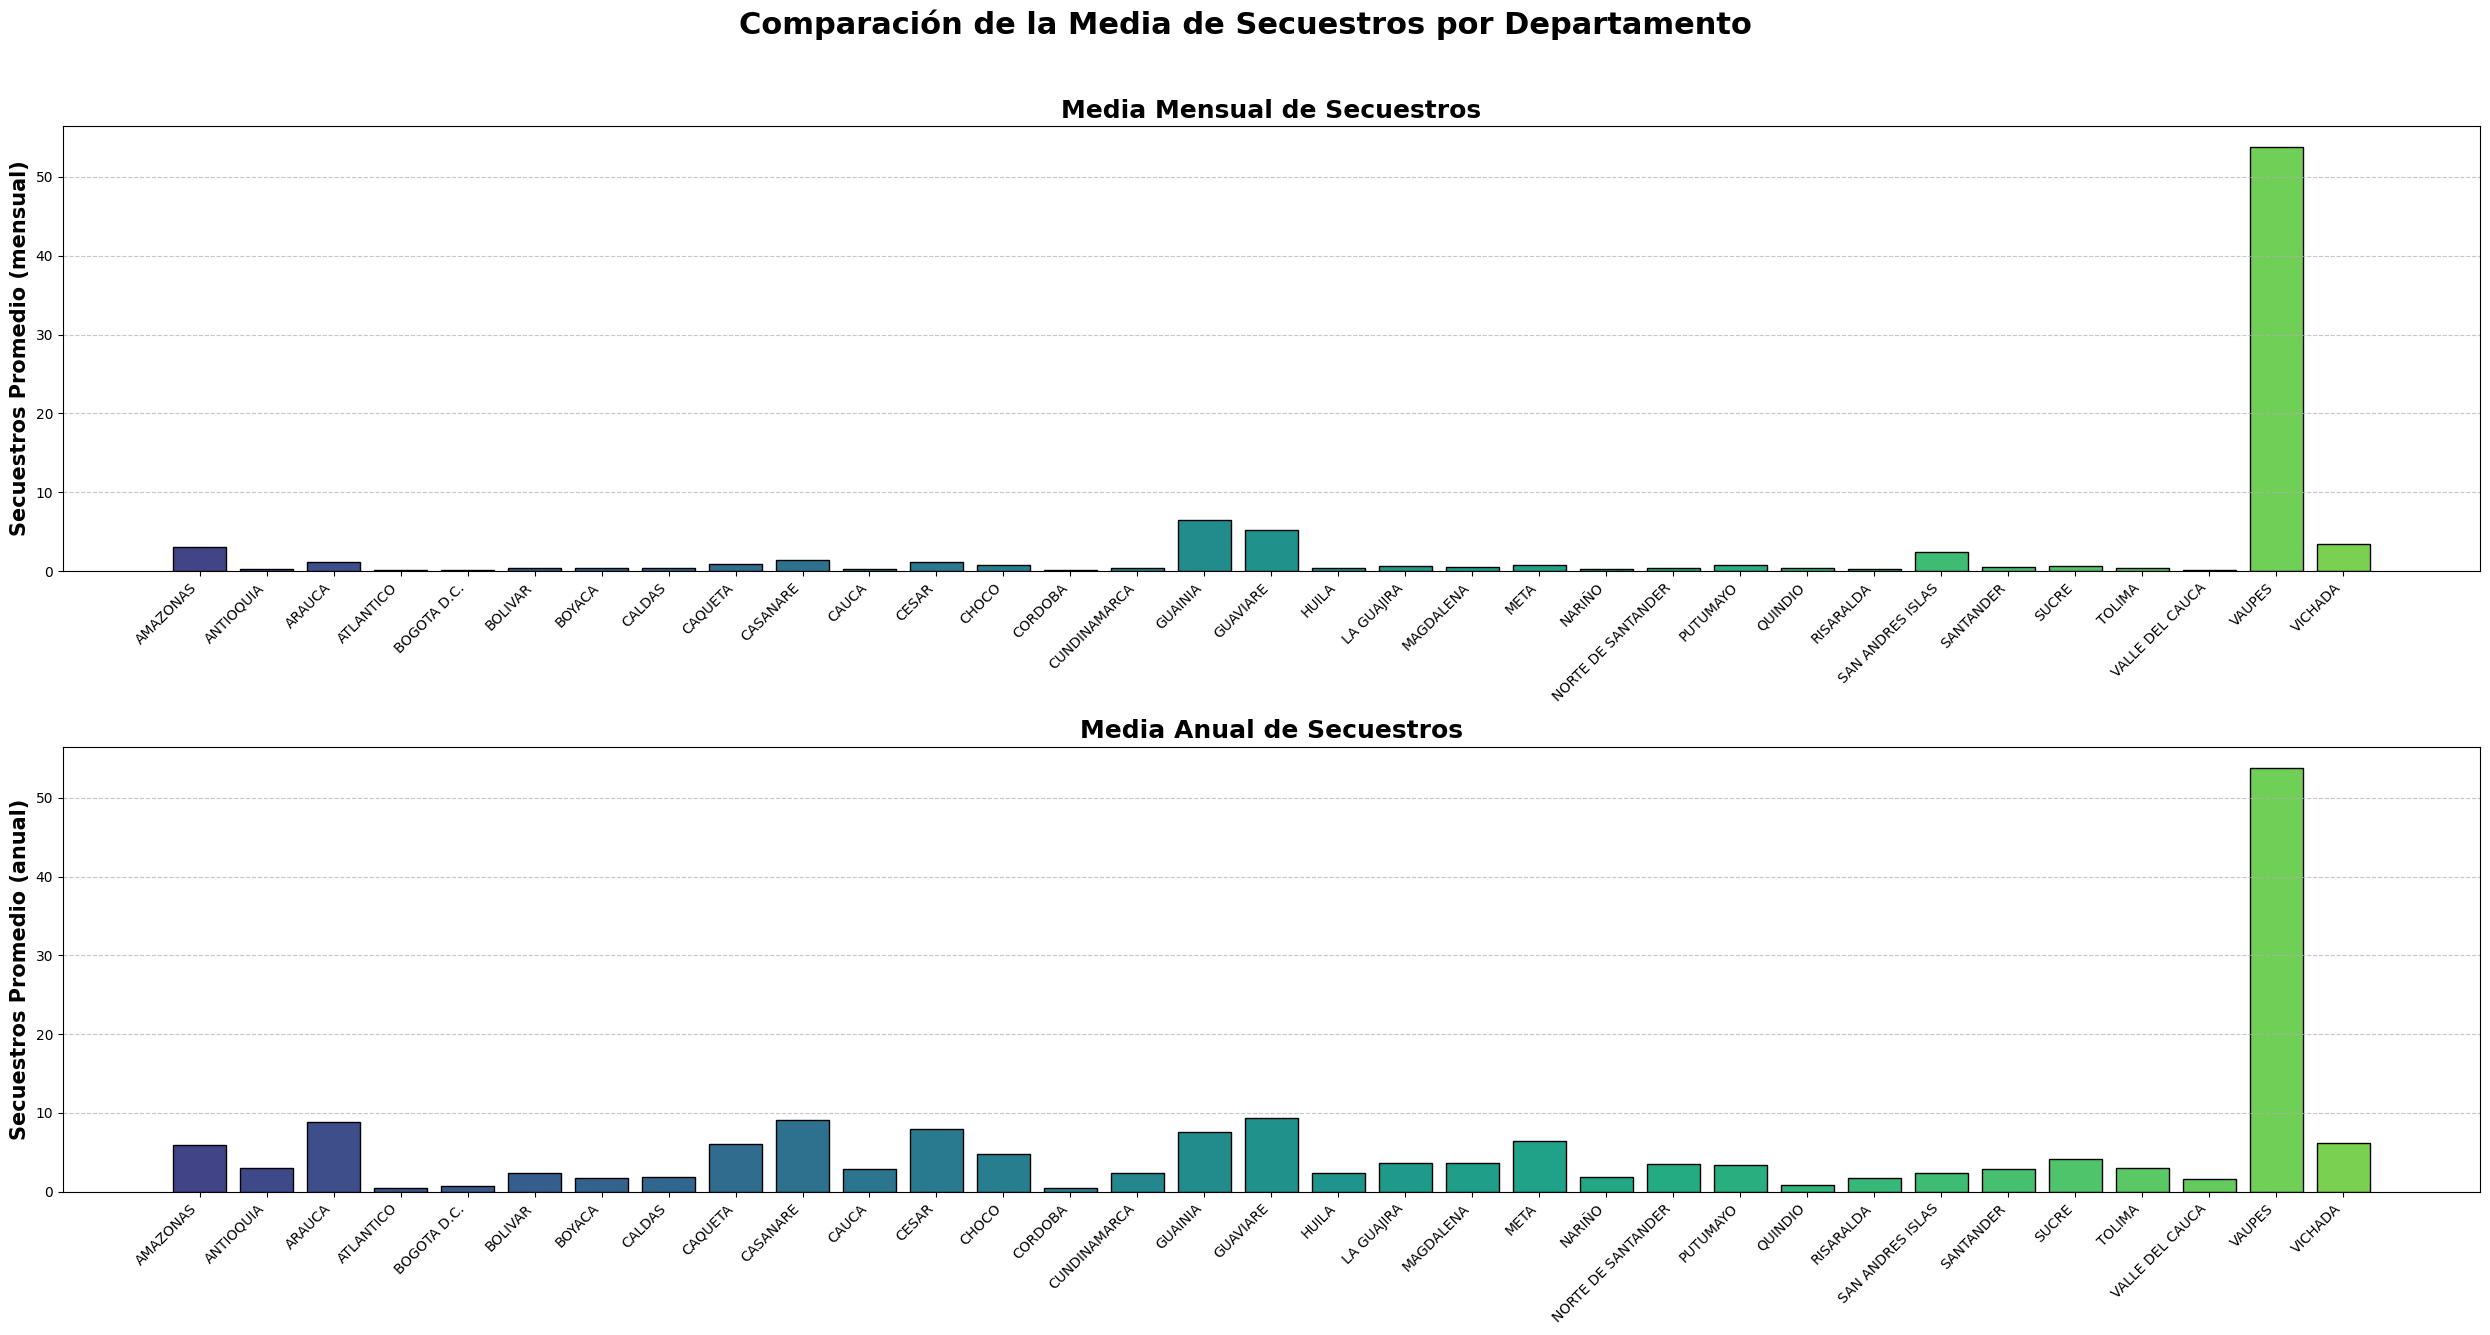

In [17]:
mean_dept_anaul = departamentos_anual.groupby('DEPARTAMENTO')['Tasa_100k'].mean().reset_index()
mean_dept_mens = departamentos_mensual.groupby('DEPARTAMENTO')['Tasa_100k'].mean().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(25, 14), sharex=False)
fig.suptitle('Comparación de la Media de Secuestros por Departamento',fontsize=22, fontweight='bold', y=0.95)

cmap = plt.cm.viridis    

x_mensual = np.arange(len(mean_dept_anaul))
colors_mensual = cmap(np.linspace(0.2, 0.8, len(x_mensual)))
bars1 = axes[0].bar(
    x_mensual,
    mean_dept_mens['Tasa_100k'],
    color=colors_mensual,
    edgecolor='black')
axes[0].set_title('Media Mensual de Secuestros', fontsize=18, fontweight='bold')
axes[0].set_ylabel('Secuestros Promedio (mensual)', fontsize=15, fontweight='bold')
axes[0].set_xticks(x_mensual)
axes[0].set_xticklabels(mean_dept_mens['DEPARTAMENTO'], rotation=45, ha='right', fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

x_anual = np.arange(len(mean_dept_mens))
colors_anual = cmap(np.linspace(0.2, 0.8, len(x_anual)))
bars2 = axes[1].bar(
    x_anual,
    mean_dept_anaul['Tasa_100k'],
    color=colors_anual,
    edgecolor='black')

axes[1].set_title('Media Anual de Secuestros', fontsize=18, fontweight='bold')
axes[1].set_ylabel('Secuestros Promedio (anual)', fontsize=15, fontweight='bold')
axes[1].set_xticks(x_anual)
axes[1].set_xticklabels(mean_dept_anaul['DEPARTAMENTO'], rotation=45, ha='right', fontsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

This comparison of monthly and annual kidnapping rates per million inhabitants confirms the extreme imbalance observed in the previous tables. Vaupés leads the ranking with a monthly average of over **50 kidnappings per million** and an almost identical annual value, indicating that most cases concentrated in that department occurred in very few months. Vichada appears in a distant second place with around **6 per million**, while all other departments fall below **3–4 kidnappings per million**, including Amazonas and Arauca.

The proximity between the monthly and annual bars for each department shows that, in almost all cases, kidnappings cluster in specific high-violence months rather than being evenly distributed throughout the year. Only a few secondary departments (Caquetá, Casanare, Guaviare) reach monthly averages of **1–2 per million**, leaving the rest of the country with residual, stable rates near zero.  



## **Analisis de la serie de la tasa creada para todo el pais**

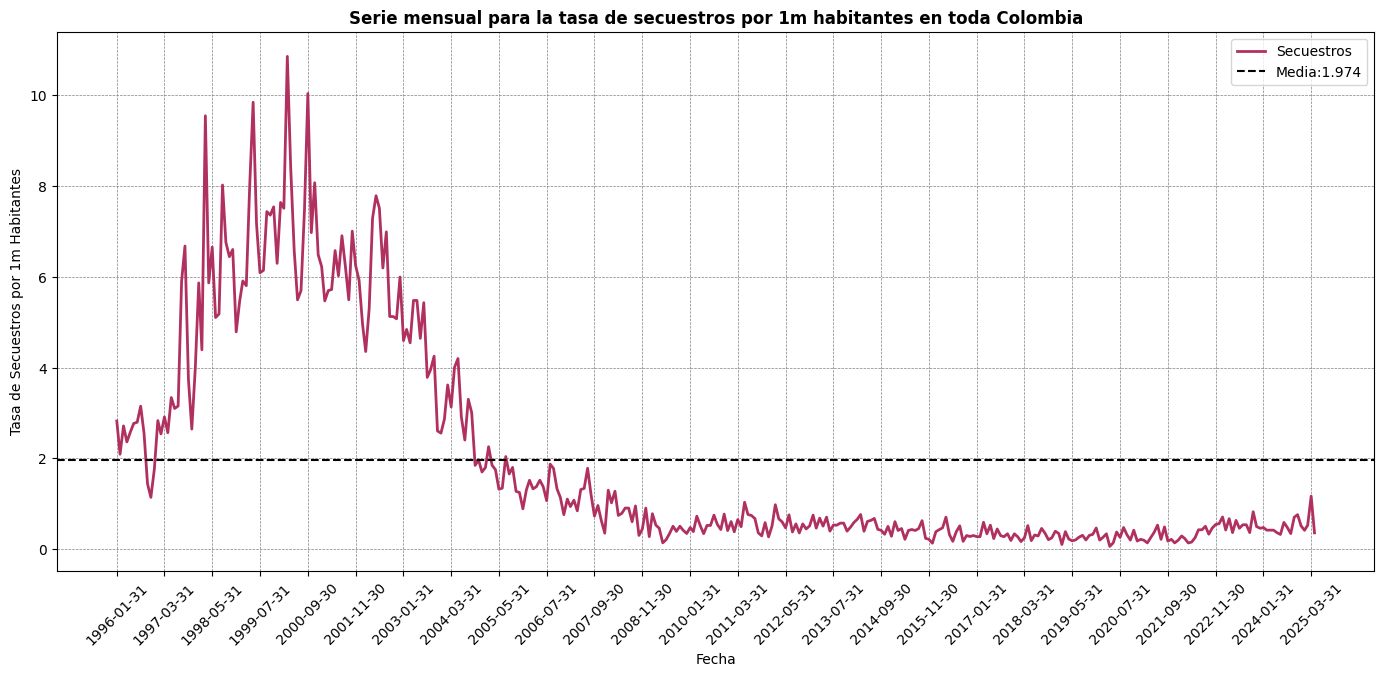

In [24]:
mean = serie_colombia_mensual['Tasa_100k'].mean()

plt.figure(figsize=(17, 7))    
plt.plot(serie_colombia_mensual['Fecha'], serie_colombia_mensual['Tasa_100k'] ,label="Secuestros", 
         linewidth=2 , color='#B03060')
plt.axhline(mean, color='black', linestyle='--', label=f'Media:{round(mean,3)}')
cuartiles_a_mostrar = serie_colombia_mensual['Fecha'][::14]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Tasa de Secuestros por 1m Habitantes')
plt.title('Serie mensual para la tasa de secuestros por 1m habitantes en toda Colombia' , weight='bold')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

The series of monthly kidnapping rates per million inhabitants clearly reflects the pulse of violence in Colombia: between 1998 and 2001 the peaks exceed 10 kidnappings per million per month. From 2002 onward, the curve drops rapidly and stabilizes below 2 per million from 2007 until 2021, showing a drastic reduction in relative terms.

Since 2022 there has been a slight uptick, bringing the rate back above 0.5–1 per million, indicating sporadic episodes of kidnapping reactivation by dissident and new armed groups. On average, the historical rate is around 2 kidnappings per million, but the curve’s profile underscores how unmatched the late ’90s–2000 levels are compared to the last two decades.  



## **Analisis Geografico mas detallado para la tasa de secuestros por 100k hab** 

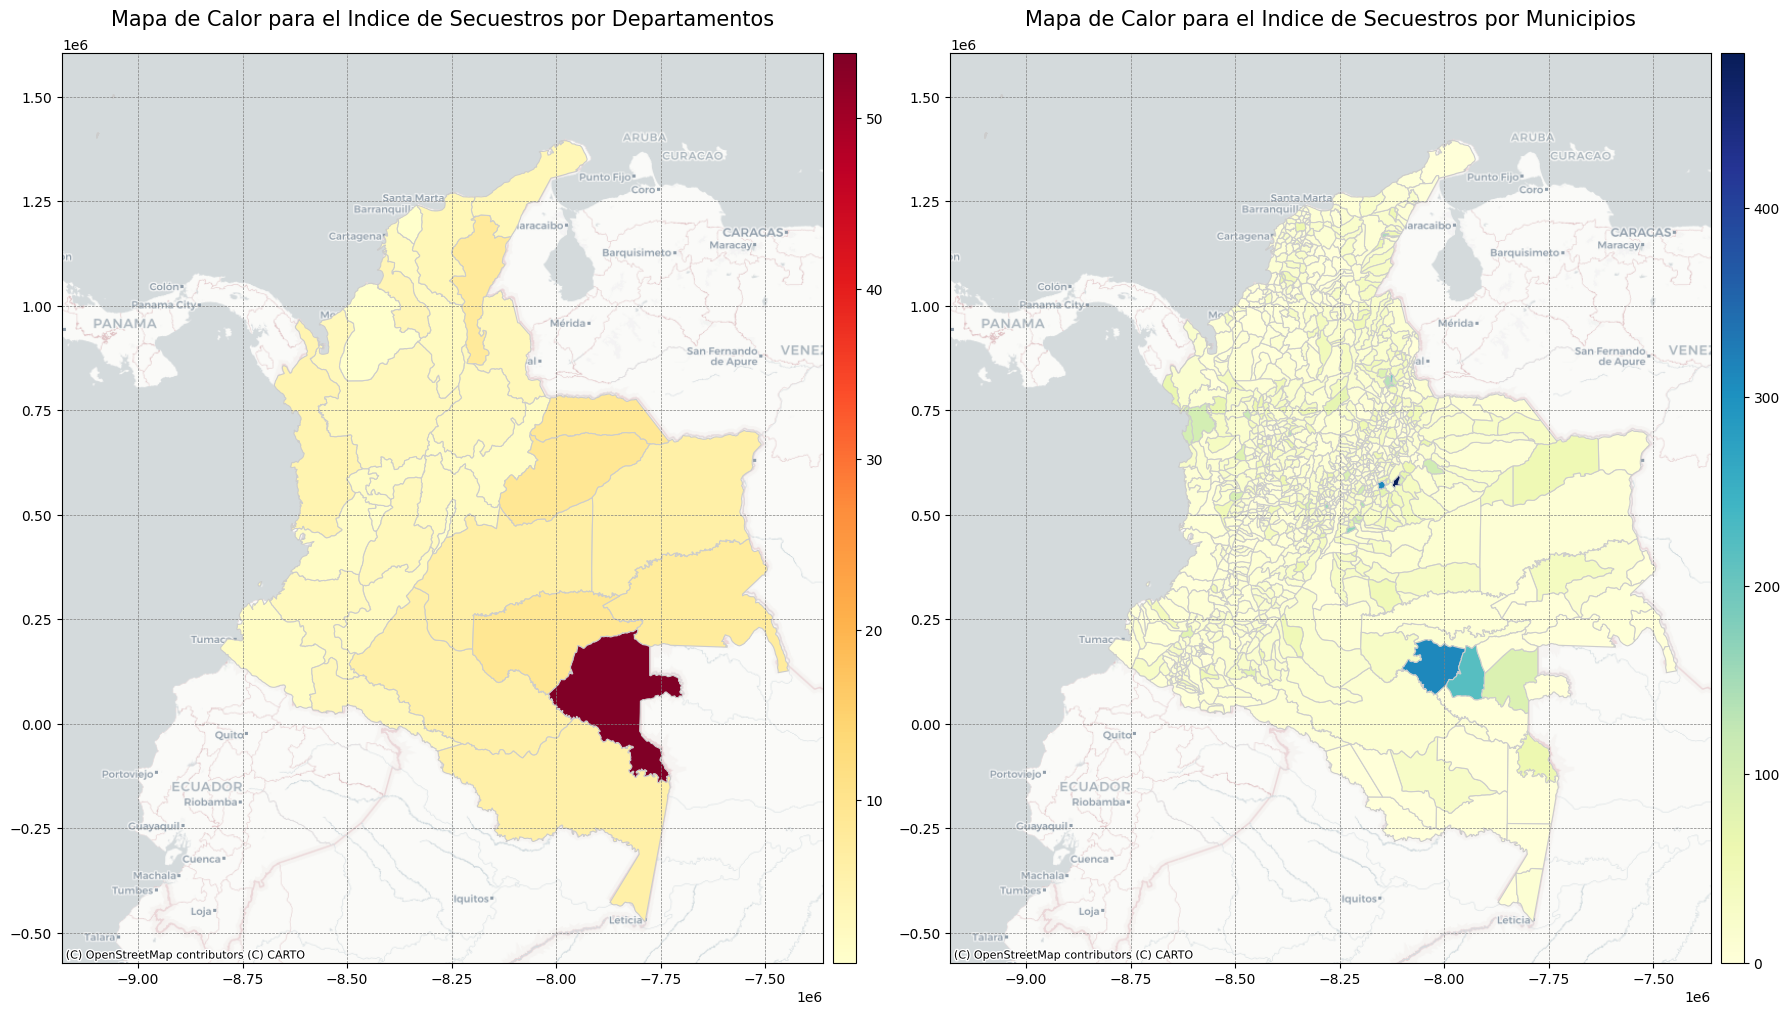

In [18]:
gdf_dept = gpd.read_file('../Datos/Colombia.json')
gdf_muni = gpd.read_file('../Datos/Colombia_municipios.geojson')

## Geo dataframe por departamento
departamento_total_casos = (departamentos_anual.groupby(['DEPARTAMENTO', 'COD_DEPTO'])
    .agg({'Tasa_100k': 'mean','TOTAL': 'sum'}).reset_index())

gdf_dept['DPTO'] = gdf_dept['DPTO'].astype(int)
departamento_total_casos['DPTO'] = departamento_total_casos['COD_DEPTO'].astype(int)
gdf_dept1 = gdf_dept.merge(departamento_total_casos[['DPTO', 'Tasa_100k' , 'TOTAL']], on='DPTO' ,how='left' ,suffixes=('','_agg'))

## Geo dataframe por municipio
municipios_total_casos = (municipios_anual.groupby(['MUNICIPIO', 'COD_DEPTO'])
    .agg({'Tasa_100k': 'mean','TOTAL': 'sum'}).reset_index())
gdf_muni['MUNICIPIO'] = gdf_muni['nombre_mpi'].astype(str)
municipios_total_casos['MUNICIPIO'] = municipios_total_casos['MUNICIPIO'] .astype(str)
gdf_muni1 = gdf_muni.merge(municipios_total_casos[['MUNICIPIO', 'Tasa_100k' , 'TOTAL']], on='MUNICIPIO' ,how='left' ,suffixes=('','_agg')).drop(columns=['geo_point_2d',])
gdf_muni1[['Tasa_100k' , 'TOTAL']] = gdf_muni1[['Tasa_100k' , 'TOTAL']].fillna(0)

gdf_dept1 = gdf_dept1.to_crs(epsg=3857)
gdf_muni1 = gdf_muni1.to_crs(epsg=3857)

## Mapa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

gdf_dept1.plot(column='Tasa_100k',cmap='YlOrRd',linewidth=0.8,edgecolor='0.8',ax=ax1,legend=True,cax=cax1)

ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax1.set_title("Mapa de Calor para el Indice de Secuestros por Departamentos", fontsize=15, pad=20)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)

gdf_muni1.plot(column='Tasa_100k',cmap='YlGnBu',linewidth=0.8,edgecolor='0.8', ax=ax2,legend=True,cax=cax2)

ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax2.set_title("Mapa de Calor para el Indice de Secuestros por Municipios", fontsize=15, pad=20)

plt.tight_layout()
plt.show()


The comparison between the index map and the absolute values map (see Script 1) reveals how the chosen metric completely alters the spatial interpretation:

- **Absolute values** (previously analyzed): Antioquia and Valle del Cauca appear in intense red, as they concentrate the highest raw number of kidnappings. Bogotá D.C. and Meta also stand out, reflecting the large volumes attributable to their population size and territorial extent.

- **Relative index** (current analysis): when standardized per million inhabitants, hotspots clearly shift to the Eastern Plains and the southern region of the country. Territories like Vaupés, Guaviare, and Caquetá—famous in the ’90s for FARC presence and their status as “lost territory”—exceed 50 kidnappings per million, while departments such as Antioquia or Valle del Cauca appear in very pale tones despite their high absolute counts. This is mainly because, in the plains, even a few kidnappings translate into very high per-capita rates.

The absolute map shows “where most kidnappings occurred,” whereas the index reveals “where the per-capita risk was most critical” and where the majority of the violence in the country was concentrated.  



***
# 3. Analysis of Kidnappings with Armed Group Presence  

***

To analyze violence and armed groups, we have three datasets, each containing a different indicator of armed group actions: **Armed Engagements** (such as clashes with the state or between groups), **Selective Killings** (premeditated murders carried out by illegal armed groups), and **Massacres**, which are a key indicator of armed group operations. All of these datasets are compiled by SIEVCAC and consist of a series where each row represents one of the events described above.

It is worth noting that for data cleaning and aggregation we will use the last function found in `construccion_bases_series.py`.  


## **War Actions**

#### Loading and debugging the database

In [28]:
acciones_belicas = pd.read_csv('../Datos/Eventos_de_Violencia_del_Conflicto_Armado_Acciones Bélicas.csv')

# Primero seleccionamos las columnas de importancia para el analisis
lista = ['Año' , 'Mes', 'Día' , 'Código DANE de Municipio' , 'Municipio', 'Departamento' ,'Grupo Armado 1', 'Grupo Armado 2' ,'Total Combatientes', 'Total de Víctimas del Caso' ,'latitud-longitud']

acciones_belicas_depurado , acciones_belicas_geo = depurar_base(acciones_belicas, lista)
acciones_belicas_depurado.head(5)

Código DANE de Municipio           Municipio Departamento  \
0                    27073              BAGADO        CHOCO   
3                    41676         SANTA MARIA        HUILA   
4                    85010             AGUAZUL     CASANARE   
5                    EXVEN  FRONTERA VENEZUELA     EXTERIOR   
6                    20238            EL COPEY        CESAR   

      Grupo Armado 1     Grupo Armado 2  Total Combatientes  \
0  AGENTE DEL ESTADO          GUERRILLA                   0   
3          GUERRILLA  GRUPO PARAMILITAR                   6   
4  AGENTE DEL ESTADO          GUERRILLA                   2   
5  AGENTE EXTRANJERO          GUERRILLA                   2   
6  AGENTE DEL ESTADO          GUERRILLA                   1   

   Total de Víctimas del Caso                   latitud-longitud       fecha  
0                           1  POINT (-76.197969065 5.503119772)  2006-03-12  
3                           6        POINT (-75.587213 2.937628)  1966-01-31  
4                           2   POINT (-72.45852372 5.100675341)  1996-02-17  
5                           2                 POINT (-72.73 9.1)  1996-02-17  
6                           1   POINT (-73.91282064 10.19995356)  1996-02-17

### Join base to the bases we have worked on

In [29]:
excluir = ['BANDOLERISMO', 'DESCONOCIDO', 'OTRO ¿CUÁL?' , 'AGENTE EXTRANJERO' , 'GRUPO ARMADO NO DIRIMIDO']

acciones_belicas_depurado = acciones_belicas_depurado[~acciones_belicas_depurado['Grupo Armado 2'].isin(excluir)]
acciones_belicas_depurado['fecha'] = pd.to_datetime(acciones_belicas_depurado['fecha'])

# Extraer año-mes para agrupar por mes
acciones_belicas_depurado['year_month'] = acciones_belicas_depurado['fecha'].dt.to_period('Y')

# Crea dummies de los grupos
dummies_grupo = pd.get_dummies(acciones_belicas_depurado['Grupo Armado 2'], prefix='G2')
dummies_grupo1 = pd.get_dummies(acciones_belicas_depurado['Grupo Armado 1'], prefix='G1')
acciones_belicas_depurado2 = pd.concat([acciones_belicas_depurado, dummies_grupo , dummies_grupo1], axis=1)

cols_sum = list(dummies_grupo.columns) + list(dummies_grupo1.columns)  + ['Total Combatientes', 'Total de Víctimas del Caso'] 

acciones_belicas_depurado2 = (acciones_belicas_depurado2.groupby(['Municipio', 'year_month' , 'Código DANE de Municipio'])[cols_sum]
    .sum().reset_index())

acciones_belicas_depurado2['year_month'] = acciones_belicas_depurado2['year_month'].dt.to_timestamp()
acciones_belicas_depurado2['AÑO'] = acciones_belicas_depurado2['year_month'].dt.year.astype(int)
acciones_belicas_depurado2 = acciones_belicas_depurado2.rename(columns={'Municipio': 'MUNICIPIO'})

## Hacer el Merge con el df anual por municipio de secuestros 
municipios_anual_crimen = municipios_anual.merge(acciones_belicas_depurado2[cols_sum + ['MUNICIPIO' ,'AÑO']], on=['MUNICIPIO','AÑO'] ,how='left' ,suffixes=('','_agg'))
municipios_anual_crimen = municipios_anual_crimen.fillna(0)
municipios_anual_crimen 

AÑO  COD_DEPTO DEPARTAMENTO  COD_MUNI   MUNICIPIO  N_SIMPLE  \
0     1996          5    ANTIOQUIA      5001    MEDELLIN         8   
1     1996          5    ANTIOQUIA      5002   ABEJORRAL         0   
2     1996          5    ANTIOQUIA      5030       AMAGA         0   
3     1996          5    ANTIOQUIA      5031      AMALFI         1   
4     1996          5    ANTIOQUIA      5034       ANDES         0   
...    ...        ...          ...       ...         ...       ...   
6764  2025         81       ARAUCA     81065   ARAUQUITA         4   
6765  2025         81       ARAUCA     81736    SARAVENA         4   
6766  2025         81       ARAUCA     81794        TAME         5   
6767  2025         85     CASANARE     85001       YOPAL         0   
6768  2025         95     GUAVIARE     95025  EL RETORNO         0   

      N_EXTORSIVO  TOTAL  Población  Tasa_100k  ...  G1_BANDOLERISMO  \
0              73     81    1787831   4.530630  ...              0.0   
1               2      2      25094   7.970033  ...              0.0   
2               2      2      25201   7.936193  ...              0.0   
3               1      2      20966   9.539254  ...              0.0   
4               2      2      41359   4.835707  ...              0.0   
...           ...    ...        ...        ...  ...              ...   
6764            0      4      64172   6.233248  ...              0.0   
6765            0      4      65754   6.083280  ...              0.0   
6766            0      5      54772   9.128752  ...              0.0   
6767            1      1     196758   0.508239  ...              0.0   
6768            2      2      17957  11.137718  ...              0.0   

      G1_CRIMEN ORGANIZADO  G1_DESCONOCIDO  G1_GRUPO ARMADO NO IDENTIFICADO  \
0                      0.0             0.0                              0.0   
1                      0.0             0.0                              0.0   
2                      0.0             0.0                              0.0   
3                      0.0             0.0                              0.0   
4                      0.0             0.0                              0.0   
...                    ...             ...                              ...   
6764                   0.0             0.0                              0.0   
6765                   0.0             0.0                              0.0   
6766                   0.0             0.0                              0.0   
6767                   0.0             0.0                              0.0   
6768                   0.0             0.0                              0.0   

      G1_GRUPO PARAMILITAR  G1_GRUPO POSDESMOVILIZACIÓN  G1_GUERRILLA  \
0                      0.0                          0.0           1.0   
1                      0.0                          0.0           0.0   
2                      0.0                          0.0           0.0   
3                      0.0                          0.0           0.0   
4                      0.0                          0.0           0.0   
...                    ...                          ...           ...   
6764                   0.0                          0.0           0.0   
6765                   0.0                          0.0           0.0   
6766                   0.0                          0.0           0.0   
6767                   0.0                          0.0           0.0   
6768                   0.0                          0.0           0.0   

      G1_OTRO ¿CUÁL?  Total Combatientes  Total de Víctimas del Caso  
0                0.0                12.0                        13.0  
1                0.0                 5.0                         5.0  
2                0.0                 0.0                         0.0  
3                0.0                 0.0                         0.0  
4                0.0                 6.0                         6.0  
...              ...                 ...         

### **Chart the number of incidents of War Actions in the Country**

Since there are many individual records, plotting each one separately on the maps would be cluttered. Therefore, we will use **DBSCAN** (an unsupervised ML clustering algorithm that automatically determines the number of clusters) to group armed engagement events within a kilometer buffer (and, later, the other conflict variables) into clusters, where larger clusters will form in areas with the highest concentration of armed group activity.  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


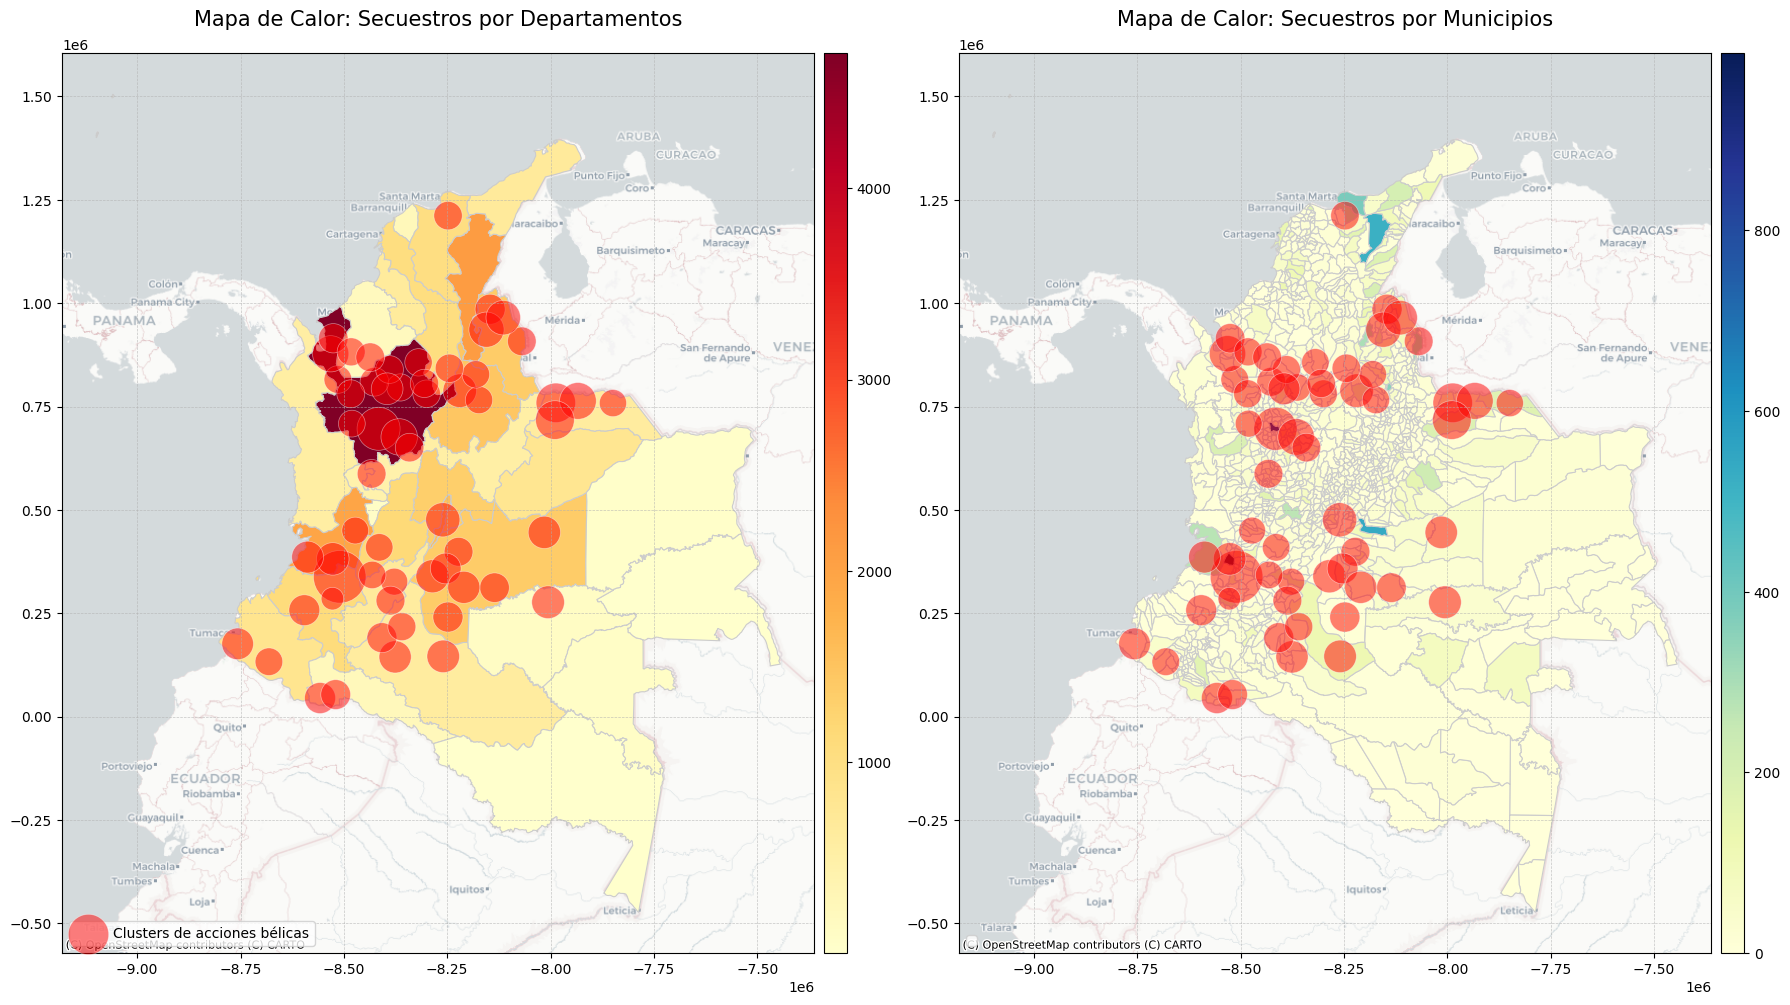

In [242]:
# Pasar todos los sistemas de coordenadas a uno igual 
gdf_dept1 = gdf_dept1.to_crs(epsg=3857)
gdf_muni1 = gdf_muni1.to_crs(epsg=3857)
acciones_belicas_geo = acciones_belicas_geo.to_crs(epsg=3857) # Usamos la base geografica que creamos donde aun no agrupamos por municipio. Es decir 
                                                              # esta base cada fila aun son eventos por separado en suelto, para asi poder graficarlos como burbujas

# Debido a que tenemos muchos puntos de violencia usaremos DBSCAN para generar clusteres con violencia 
coords = np.vstack([acciones_belicas_geo.geometry.x,acciones_belicas_geo.geometry.y]).T

db = DBSCAN(eps=15000, min_samples=150, metric='euclidean').fit(coords) # El criterio sera en un radio de 15km y con minimo 150 casos de violencia 
acciones_belicas_geo['cluster'] = db.labels_

cl = acciones_belicas_geo[acciones_belicas_geo.cluster >= 0]

clusters = (cl.dissolve(by='cluster').geometry.centroid.to_frame(name='geometry'))
counts = cl.groupby('cluster').size().rename('count')
clusters = clusters.join(counts, on='cluster')
clusters = gpd.GeoDataFrame(clusters, geometry='geometry', crs=acciones_belicas_geo.crs)

# Garantizamos que todos los clusters queden en la region geografica de Colombia 
xmin, ymin, xmax, ymax = gdf_muni1.total_bounds
clusters_in = clusters[
    (clusters.geometry.x >= xmin) & (clusters.geometry.x <= xmax) &
    (clusters.geometry.y >= ymin) & (clusters.geometry.y <= ymax)]

######## GRAFICA ############# 

clusters_in['size'] = np.sqrt(clusters_in['count']) * 30  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

## Grafico para los Departamentos 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

gdf_dept1.plot(column='TOTAL',cmap='YlOrRd',linewidth=0.8,
    edgecolor='0.8',ax=ax1,legend=True,cax=cax1)
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_title("Mapa de Calor: Secuestros por Departamentos", fontsize=15, pad=20)

## Superponer los clusters encontrados con DBSCAN
clusters_in.plot(ax=ax1,markersize=clusters_in['size'],alpha=0.5,
    color='red',edgecolor='white',linewidth=0.5,
    label='Clusters de acciones bélicas')
ax1.legend(loc='lower left')

## Grafico para los Municipios
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)

gdf_muni1.plot(column='TOTAL',cmap='YlGnBu',
    linewidth=0.8,edgecolor='0.8',ax=ax2,
    legend=True,cax=cax2)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax2.set_title("Mapa de Calor: Secuestros por Municipios", fontsize=15, pad=20)

## Superponer los clusters encontrados con DBSCAN
clusters_in.plot(ax=ax2,markersize=clusters_in['size'],alpha=0.5,
    color='red',edgecolor='white',linewidth=0.5)
ax2.legend(loc='lower left')


plt.tight_layout()
plt.show()

In this second map, the red bubbles—which represent guerrilla armed engagements and armed conflicts—are concentrated in the same departments with the highest absolute number of kidnappings (Antioquia, Valle del Cauca, Santander, Meta), reinforcing the direct association between guerrilla presence and kidnapping volume.

At the municipal level, the distribution is similar, with large bubbles in capitals and departments that have the greatest number of kidnappings. However, the correlation is not perfect: some municipalities within “hot” departments show less guerrilla activity than expected, and vice versa, suggesting local dynamics and differences in the effectiveness of territorial control.  

 


## **Targeted Killings**

This will be the second proxy to measure in which departments and municipalities the violence was concentrated.

#### Loading and debugging the database

In [30]:
asses = pd.read_csv('Datos/Eventos_de_Violencia_del_Conflicto_Armado_Asesinatos.csv')
lista = ['Año', 'Mes', 'Día' , 'Código DANE de Municipio', 'Municipio', 'Departamento'  ,'latitud-longitud' ]
asses_depurado , asses_geo = depurar_base(asses, lista)
asses_depurado.head()

C:\Users\alejo\AppData\Local\Temp\ipykernel_4176\1063770319.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  asses = pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\Maestria Inteligencia de negocios\\Segundo Semestre\\Seminario Programacion\\Proyecto 1\\Datos\\Eventos_de_Violencia_del_Conflicto_Armado_Asesinatos.csv')


Código DANE de Municipio   Municipio  Departamento  \
0                    25290  FUSAGASUGA  CUNDINAMARCA   
1                    25290  FUSAGASUGA  CUNDINAMARCA   
2                    25290  FUSAGASUGA  CUNDINAMARCA   
3                    25290  FUSAGASUGA  CUNDINAMARCA   
4                    25290  FUSAGASUGA  CUNDINAMARCA   

                    latitud-longitud       fecha  
0  POINT (-74.388591139 4.323534028)  2003-10-27  
1   POINT (-74.38859114 4.323534028)  2003-11-24  
2   POINT (-74.38859114 4.323534028)  2003-11-24  
3   POINT (-74.38859114 4.323534028)  2003-11-24  
4   POINT (-74.38859114 4.323534028)  2004-01-01

### Group the new columns of War Actions into the kidnapping database we are working on.

In [31]:
asses_depurado['fecha'] = pd.to_datetime(asses_depurado['fecha'])
asses_depurado['AÑO'] = asses_depurado['fecha'].dt.year
asses_depurado = (asses_depurado.groupby(['Código DANE de Municipio',
        'Municipio','Departamento','AÑO'], as_index=False).size().rename(columns={'size': 'Asesinatos Selectivos'}))
asses_depurado = asses_depurado.rename(columns={'Municipio': 'MUNICIPIO'})
asses_depurado

municipios_anual_asesinatos = municipios_anual_crimen.merge(asses_depurado[['MUNICIPIO' ,'AÑO' ,'Asesinatos Selectivos']], on=['MUNICIPIO','AÑO'] ,how='left' ,suffixes=('','_agg'))
municipios_anual_asesinatos = municipios_anual_asesinatos.fillna(0)
municipios_anual_asesinatos.shape  # Podemos ver que tenemos una columna extra que corresponde a los Asesinatos Selectivos

(9768, 31)

### Graph the number of targeted killings in the country again using DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


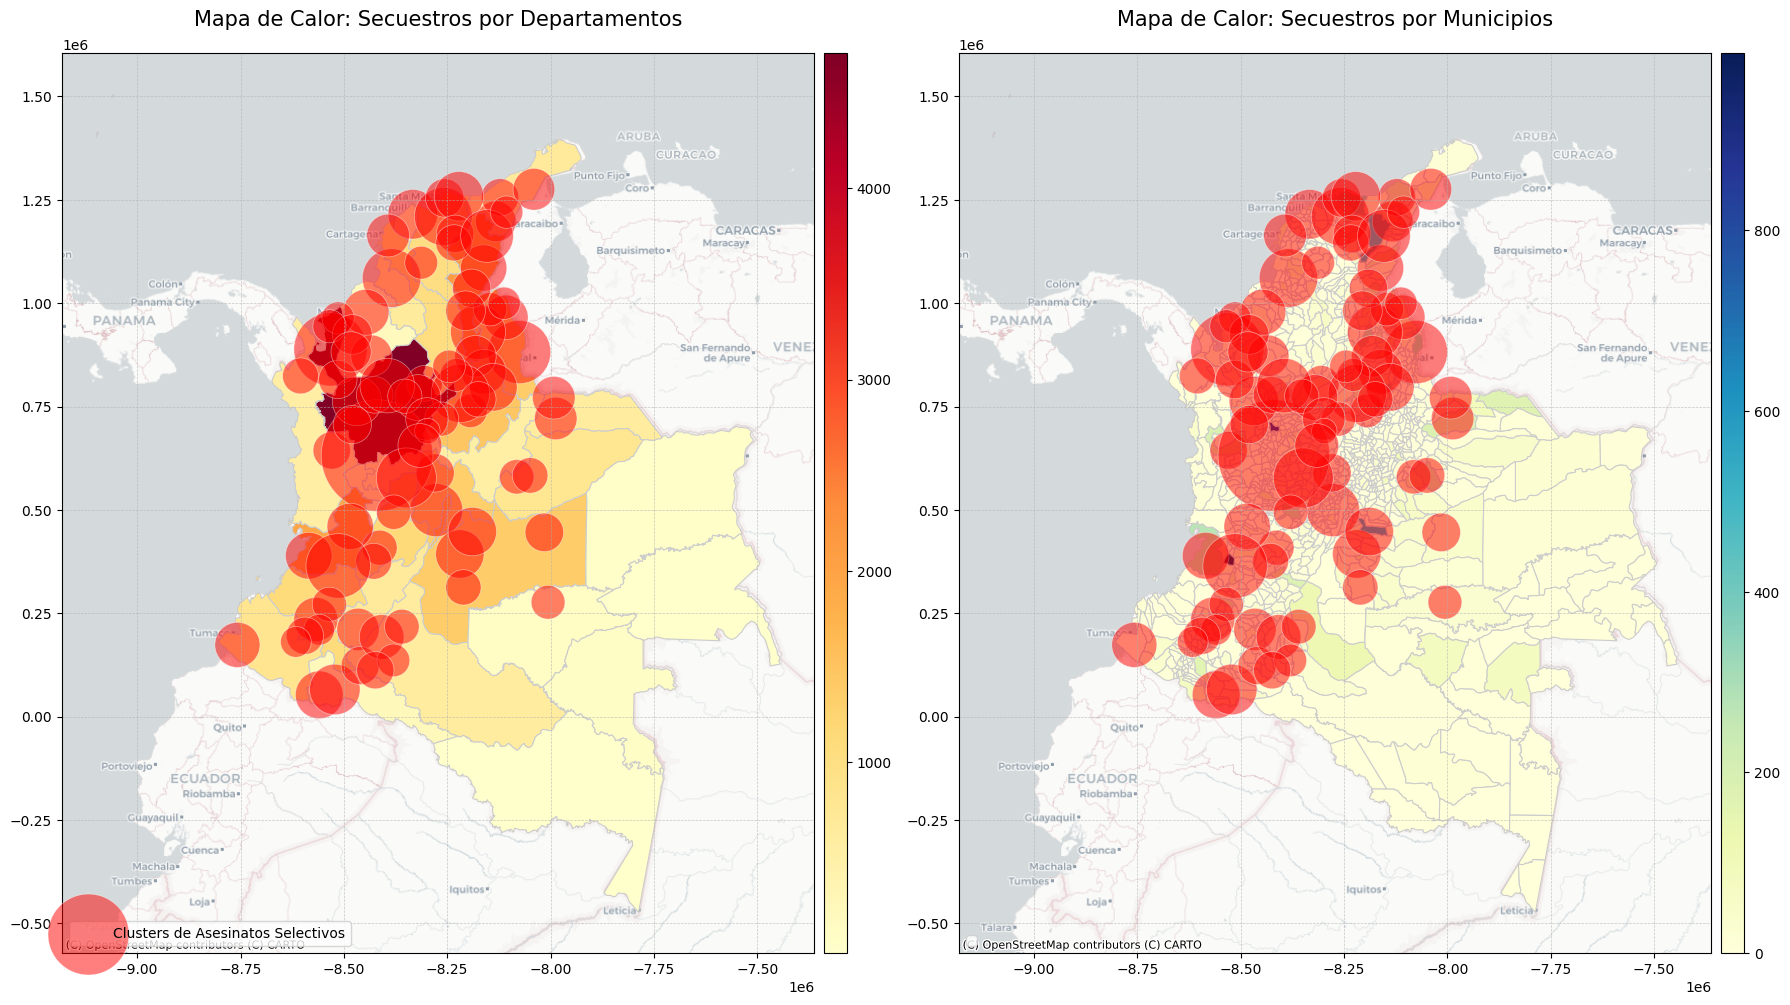

In [258]:
gdf_dept1 = gdf_dept1.to_crs(epsg=3857)
gdf_muni1 = gdf_muni1.to_crs(epsg=3857)
asses_geo = asses_geo.to_crs(epsg=3857)

# Debido a que tenemos muchos puntos de violencia usaremos DBSCAN para generar clusteres con violencia 
coords = np.vstack([asses_geo.geometry.x,asses_geo.geometry.y]).T

db = DBSCAN(eps=15000, min_samples=320, metric='euclidean').fit(coords) # El criterio sera en un radio de 15km y con minimo 320 casos de asesinatos selectivos 
asses_geo['cluster'] = db.labels_

cl = asses_geo[asses_geo.cluster >= 0]

clusters = (cl.dissolve(by='cluster').geometry.centroid.to_frame(name='geometry'))
counts = cl.groupby('cluster').size().rename('count')
clusters = clusters.join(counts, on='cluster')
clusters = gpd.GeoDataFrame(clusters, geometry='geometry', crs=asses_geo.crs)

# Garantizamos que todos los clusters queden en la region geografica de Colombia 
xmin, ymin, xmax, ymax = gdf_muni1.total_bounds
clusters_in = clusters[
    (clusters.geometry.x >= xmin) & (clusters.geometry.x <= xmax) &
    (clusters.geometry.y >= ymin) & (clusters.geometry.y <= ymax)]

######## GRAFICA ############# 

clusters_in['size'] = np.sqrt(clusters_in['count']) * 30  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

## Grafico para los Departamentos 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

gdf_dept1.plot(column='TOTAL',cmap='YlOrRd',linewidth=0.8,
    edgecolor='0.8',ax=ax1,legend=True,cax=cax1)
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_title("Mapa de Calor: Secuestros por Departamentos", fontsize=15, pad=20)

## Superponer los clusters encontrados con DBSCAN
clusters_in.plot(ax=ax1,markersize=clusters_in['size'],alpha=0.5,
    color='red',edgecolor='white',linewidth=0.5,
    label='Clusters de Asesinatos Selectivos')
ax1.legend(loc='lower left')

## Grafico para los Municipios
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)

gdf_muni1.plot(column='TOTAL',cmap='YlGnBu',
    linewidth=0.8,edgecolor='0.8',ax=ax2,
    legend=True,cax=cax2)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax2.set_title("Mapa de Calor: Secuestros por Municipios", fontsize=15, pad=20)

## Superponer los clusters encontrados con DBSCAN
clusters_in.plot(ax=ax2,markersize=clusters_in['size'],alpha=0.5,
    color='red',edgecolor='white',linewidth=0.5)
ax2.legend(loc='lower left')


plt.tight_layout()
plt.show()

This map of “selective killings” shows a more dispersed pattern than armed engagements, but it reinforces the strong link between armed violence and kidnappings in absolute terms. At the departmental level, the largest bubbles again cluster in Antioquia (alongside Valle del Cauca and Santander), demonstrating that the intensity of selective killings (a good proxy for the number of armed groups) was directly proportional to the volume of kidnappings there.

At the municipal level, the correlation is even clearer: capitals like Medellín, Cali, Florencia, and the Pacific region appear with large red circles, aligning with the municipalities that also recorded high kidnapping numbers. However, the presence of bubbles scattered across the country, even in regions with few kidnappings, indicates that selective killings were a more widespread form of violence, “muddying” the metric by including conflict hotspots not necessarily linked to kidnapping dynamics.  



## **Massacres**

One problem with targeted killings is that they could occur anywhere in the country, and they don't necessarily mean that armed groups are present in that specific area. That's why we consider the first map (war actions) to be a more direct proxy for where guerrilla and paramilitary groups were concentrated. However, massacres were a defining characteristic of this violent era. With this more concentrated proxy, and with fewer cases, we believe it will be easier to truly pinpoint where illegal groups were operating in the country.

#### Loading and debugging the database

In [32]:
masacres = pd.read_csv('../Datos/Eventos_de_Violencia_del_Conflicto_Armado_Masacres.csv')
lista = ['Año', 'Mes', 'Día' , 'Código DANE de Municipio', 'Municipio', 'Departamento'  ,'Presunto Responsable','Total de Víctimas del Caso' ,'latitud-longitud']
masacres_depurado , masacres_geo = depurar_base(masacres, lista)
masacres_depurado.head(10)


Código DANE de Municipio    Municipio  Departamento  \
0                    25530  PARATEBUENO  CUNDINAMARCA   
1                    27361      ISTMINA         CHOCO   
2                    44430       MAICAO    LA GUAJIRA   
3                    44430       MAICAO    LA GUAJIRA   
4                    44430       MAICAO    LA GUAJIRA   
5                    44430       MAICAO    LA GUAJIRA   
6                    47001  SANTA MARTA     MAGDALENA   
7                    47001  SANTA MARTA     MAGDALENA   
8                    47189      CIENAGA     MAGDALENA   
9                    47268     EL RETEN     MAGDALENA   

       Presunto Responsable  Total de Víctimas del Caso  \
0         GRUPO PARAMILITAR                           5   
1  GRUPO POSDESMOVILIZACIÓN                           4   
2         GRUPO PARAMILITAR                           4   
3         GRUPO PARAMILITAR                           4   
4         GRUPO PARAMILITAR                           4   
5         GRUPO PARAMILITAR                           4   
6         GRUPO PARAMILITAR                           5   
7         GRUPO PARAMILITAR                           4   
8         GRUPO PARAMILITAR                           5   
9         GRUPO PARAMILITAR                           4   

                    latitud-longitud       fecha  
0  POINT (-73.241661397 4.368158959)  1998-01-25  
1   POINT (-77.00090737 4.586818665)  2007-10-17  
2       POINT (-72.241861 11.378319)  2005-12-07  
3       POINT (-72.241861 11.378319)  2000-06-18  
4   POINT (-72.29500818 11.38157764)  2002-06-02  
5       POINT (-72.241861 11.378319)  2002-08-06  
6   POINT (-73.88527855 11.12189436)  1988-07-12  
7   POINT (-73.88527855 11.12189436)  2002-03-07  
8   POINT (-74.02404322 10.76964718)  1988-07-12  
9       POINT (-74.268412 10.610445)  1995-05-21

### Rejoin the database that already contains information on kidnappings, as well as military actions and targeted killings.

In [33]:
excluir = ['BANDOLERISMO', 'DESCONOCIDO', 'OTRO ¿CUÁL?' , 'AGENTE EXTRANJERO' , 'GRUPO ARMADO NO DIRIMIDO', 'GRUPO ARMADO NO IDENTIFICADO', 'AGENTE DEL ESTADO']

masacres_depurado = masacres_depurado[~masacres_depurado['Presunto Responsable'].isin(excluir)]
masacres_depurado['fecha'] = pd.to_datetime(masacres_depurado['fecha'])

# Extraer año-mes para agrupar por mes
masacres_depurado['year_month'] = masacres_depurado['fecha'].dt.to_period('Y')

# Crea dummies de los grupos
dummies_grupo = pd.get_dummies(masacres_depurado['Presunto Responsable'], prefix='PR')
masacres_depurado2 = pd.concat([masacres_depurado, dummies_grupo ], axis=1)

cols_sum = list(dummies_grupo.columns)  + ['Total de Víctimas del Caso'] 

masacres_depurado2 = (masacres_depurado2.groupby(['Municipio', 'year_month' , 'Código DANE de Municipio'])[cols_sum]
    .sum().reset_index())

masacres_depurado2['year_month'] = masacres_depurado2['year_month'].dt.to_timestamp()
masacres_depurado2['AÑO'] = masacres_depurado2['year_month'].dt.year.astype(int)
masacres_depurado2 = masacres_depurado2.rename(columns={'Municipio': 'MUNICIPIO' , 'Total de Víctimas del Caso': 'Victimas Masacre'})

## Hacer el Merge con el df anual por municipio de secuestros 
municipios_anual_guerr = municipios_anual_asesinatos.merge(masacres_depurado2[list(dummies_grupo.columns) + ['MUNICIPIO' ,'AÑO' ,'Victimas Masacre']], on=['MUNICIPIO','AÑO'] ,how='left' ,suffixes=('','_agg'))
municipios_anual_guerr = municipios_anual_guerr.fillna(0)
municipios_anual_guerr 

AÑO  COD_DEPTO DEPARTAMENTO  COD_MUNI   MUNICIPIO  N_SIMPLE  \
0     1996          5    ANTIOQUIA      5001    MEDELLIN         8   
1     1996          5    ANTIOQUIA      5002   ABEJORRAL         0   
2     1996          5    ANTIOQUIA      5030       AMAGA         0   
3     1996          5    ANTIOQUIA      5031      AMALFI         1   
4     1996          5    ANTIOQUIA      5034       ANDES         0   
...    ...        ...          ...       ...         ...       ...   
9832  2025         81       ARAUCA     81065   ARAUQUITA         4   
9833  2025         81       ARAUCA     81736    SARAVENA         4   
9834  2025         81       ARAUCA     81794        TAME         5   
9835  2025         85     CASANARE     85001       YOPAL         0   
9836  2025         95     GUAVIARE     95025  EL RETORNO         0   

      N_EXTORSIVO  TOTAL  Población  Tasa_100k  ...  G1_OTRO ¿CUÁL?  \
0              73     81    1787831   4.530630  ...             0.0   
1               2      2      25094   7.970033  ...             0.0   
2               2      2      25201   7.936193  ...             0.0   
3               1      2      20966   9.539254  ...             0.0   
4               2      2      41359   4.835707  ...             0.0   
...           ...    ...        ...        ...  ...             ...   
9832            0      4      64172   6.233248  ...             0.0   
9833            0      4      65754   6.083280  ...             0.0   
9834            0      5      54772   9.128752  ...             0.0   
9835            1      1     196758   0.508239  ...             0.0   
9836            2      2      17957  11.137718  ...             0.0   

      Total Combatientes  Total de Víctimas del Caso  Asesinatos Selectivos  \
0                   12.0                        13.0                 1036.0   
1                    5.0                         5.0                    4.0   
2                    0.0                         0.0                   11.0   
3                    0.0                         0.0                   14.0   
4                    6.0                         6.0                   30.0   
...                  ...                         ...                    ...   
9832                 0.0                         0.0                    0.0   
9833                 0.0                         0.0                    0.0   
9834                 0.0                         0.0                    0.0   
9835                 0.0                         0.0                    0.0   
9836                 0.0                         0.0                    0.0   

      PR_AGENTE DEL ESTADO - GRUPO PARAMILITAR  PR_CRIMEN ORGANIZADO  \
0                                          0.0                   0.0   
1                                          0.0                   0.0   
2                                          0.0                   0.0   
3                                          0.0                   0.0   
4                                          0.0                   0.0   
...                                        ...                   ...   
9832                                       0.0                   0.0   
9833                                       0.0                   0.0   
9834                                       0.0                   0.0   
9835                                       0.0                   0.0   
9836                                       0.0                   0.0   

      PR_GRUPO PARAMILITAR  PR_GRUPO POSDESMOVILIZACIÓN  PR_GUERRILLA  \
0                      4.0                          0.0           0.0   
1                      1.0                          0.0           0.0   
2                      0.0                          0.0           0.0   
3                      0.0                          0.0           0.0   
4                      1.0                          0.0           0.0   
...                    ...                          ...      

### Since we have already finished with the variables of violence and guerrilla warfare calculated by SIEVCAC, we can add up all the number of illegal groups that we have to reduce the dimensionality of the database.

In [34]:
base_sec_violen = municipios_anual_guerr.copy()

# Usemos expresiones regulares para seleccionar aquellas que creamos con G1_, G2_ o PR_
group_cols = [col for col in base_sec_violen.columns if re.match(r'^(G1|G2|PR)_', col)]

suffix_dict = defaultdict(list)
for col in group_cols:
    suffix = col.split('_', 1)[1]   
    suffix_dict[suffix].append(col)

# Hacemos la suma de cada variable dummy
for suf, cols in suffix_dict.items():
    base_sec_violen[suf] = base_sec_violen[cols].sum(axis=1)

# Eliminar las columas con G1_, G2_ y PR_
base_sec_violen = base_sec_violen.drop(columns=group_cols)
base_sec_violen = base_sec_violen.drop(columns=['AGENTE EXTRANJERO','BANDOLERISMO', 'DESCONOCIDO', 'OTRO ¿CUÁL?'])
base_sec_violen.head(10) ## Como podemos ver redujimos el numero de columnas agrupando la cantidad de personas en cada una de las actividades como un proxy de la grupos en cada municipio

AÑO  COD_DEPTO DEPARTAMENTO  COD_MUNI             MUNICIPIO  N_SIMPLE  \
0  1996          5    ANTIOQUIA      5001              MEDELLIN         8   
1  1996          5    ANTIOQUIA      5002             ABEJORRAL         0   
2  1996          5    ANTIOQUIA      5030                 AMAGA         0   
3  1996          5    ANTIOQUIA      5031                AMALFI         1   
4  1996          5    ANTIOQUIA      5034                 ANDES         0   
5  1996          5    ANTIOQUIA      5038             ANGOSTURA         0   
6  1996          5    ANTIOQUIA      5040                 ANORI         1   
7  1996          5    ANTIOQUIA      5042  SANTAFE DE ANTIOQUIA         2   
8  1996          5    ANTIOQUIA      5045              APARTADO         1   
9  1996          5    ANTIOQUIA      5086               BELMIRA         0   

   N_EXTORSIVO  TOTAL  Población  Tasa_100k  ...  Asesinatos Selectivos  \
0           73     81    1787831   4.530630  ...                 1036.0   
1            2      2      25094   7.970033  ...                    4.0   
2            2      2      25201   7.936193  ...                   11.0   
3            1      2      20966   9.539254  ...                   14.0   
4            2      2      41359   4.835707  ...                   30.0   
5            1      1      12845   7.785130  ...                    3.0   
6            0      1      14244   7.020500  ...                    7.0   
7           10     12      21787  55.078717  ...                    0.0   
8            7      8      71480  11.191942  ...                  383.0   
9            1      1       5855  17.079419  ...                    1.0   

   Victimas Masacre  AGENTE DEL ESTADO  AGENTE DEL ESTADO - GUERRILLA  \
0              37.0                7.0                            0.0   
1               4.0                5.0                            0.0   
2               0.0                0.0                            0.0   
3               0.0                0.0                            0.0   
4               4.0                2.0                            0.0   
5               0.0                0.0                            0.0   
6               0.0               12.0                            0.0   
7               0.0                0.0                            0.0   
8              41.0               10.0                            0.0   
9               0.0                0.0                            0.0   

   CRIMEN ORGANIZADO  GRUPO ARMADO NO IDENTIFICADO  GRUPO PARAMILITAR  \
0                0.0                           3.0                4.0   
1                0.0                           0.0                1.0   
2                0.0                           0.0                0.0   
3                0.0                           0.0                0.0   
4                0.0                           0.0                1.0   
5                0.0                           0.0                0.0   
6                0.0                           0.0                0.0   
7                0.0                           0.0                0.0   
8                0.0                           2.0                8.0   
9                0.0                           0.0                0.0   

   GRUPO POSDESMOVILIZACIÓN  GUERRILLA  AGENTE DEL ESTADO - GRUPO PARAMILITAR  
0                       0.0        6.0                                    0.0  
1                       0.0        5.0                                    0.0  
2                       0.0        0.0                                    0.0  
3                       0.0        0.0                                    0.0  
4                       0.0        2.0                                    0.0  
5                       0.0        0.0                                    0.0  
6                       0.0       12.0                                    0.0  
7                       0.0        0.0                                    0.0  
8 

### Graph the number of massacres in the country using DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


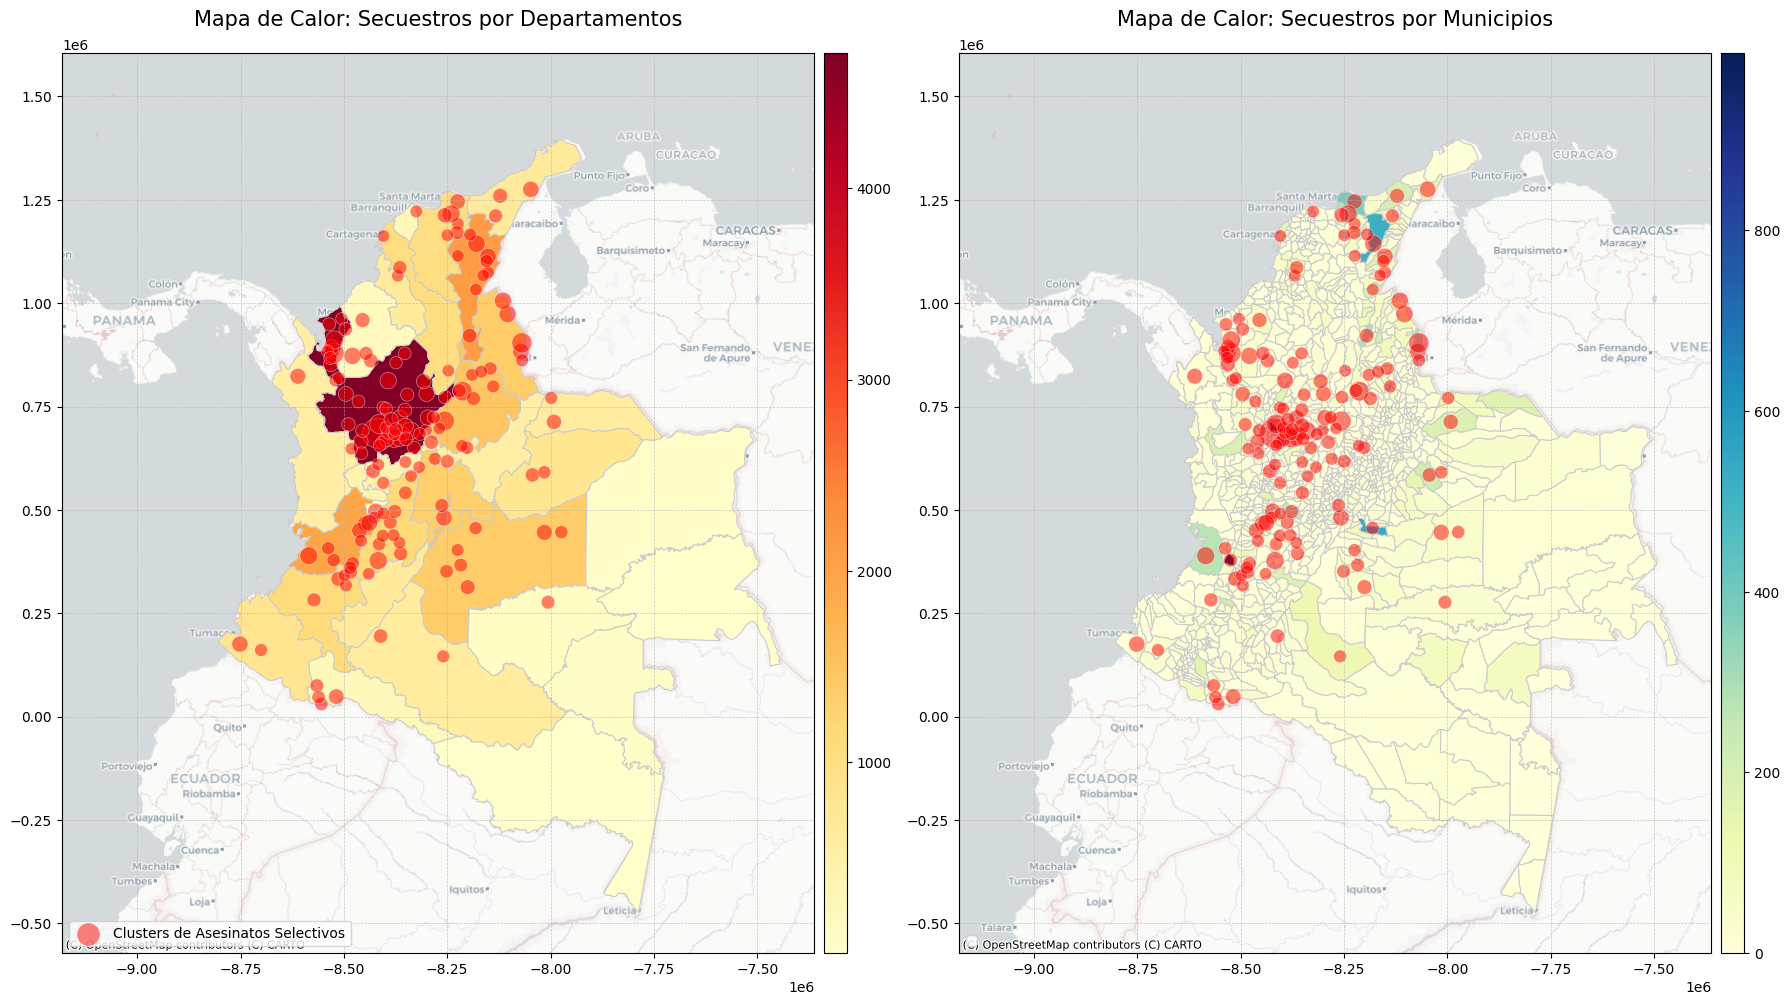

In [268]:
gdf_dept1 = gdf_dept1.to_crs(epsg=3857)
gdf_muni1 = gdf_muni1.to_crs(epsg=3857)
masacres_geo = masacres_geo.to_crs(epsg=3857)

# Debido a que tenemos muchos puntos de violencia usaremos DBSCAN para generar clusteres con violencia 
coords = np.vstack([masacres_geo.geometry.x,masacres_geo.geometry.y]).T

db = DBSCAN(eps=5000, min_samples=7, metric='euclidean').fit(coords) # El criterio sera en un radio de 15km y con minimo 320 casos de asesinatos selectivos 
masacres_geo['cluster'] = db.labels_

cl = masacres_geo[masacres_geo.cluster >= 0]

clusters = (cl.dissolve(by='cluster').geometry.centroid.to_frame(name='geometry'))
counts = cl.groupby('cluster').size().rename('count')
clusters = clusters.join(counts, on='cluster')
clusters = gpd.GeoDataFrame(clusters, geometry='geometry', crs=masacres_geo.crs)

# Garantizamos que todos los clusters queden en la region geografica de Colombia 
xmin, ymin, xmax, ymax = gdf_muni1.total_bounds
clusters_in = clusters[
    (clusters.geometry.x >= xmin) & (clusters.geometry.x <= xmax) &
    (clusters.geometry.y >= ymin) & (clusters.geometry.y <= ymax)]

######## GRAFICA ############# 

clusters_in['size'] = np.sqrt(clusters_in['count']) * 30  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

## Grafico para los Departamentos 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

gdf_dept1.plot(column='TOTAL',cmap='YlOrRd',linewidth=0.8,
    edgecolor='0.8',ax=ax1,legend=True,cax=cax1)
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_title("Mapa de Calor: Secuestros por Departamentos", fontsize=15, pad=20)

## Superponer los clusters encontrados con DBSCAN
clusters_in.plot(ax=ax1,markersize=clusters_in['size'],alpha=0.5,
    color='red',edgecolor='white',linewidth=0.5,
    label='Clusters de Asesinatos Selectivos')
ax1.legend(loc='lower left')

## Grafico para los Municipios
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)

gdf_muni1.plot(column='TOTAL',cmap='YlGnBu',
    linewidth=0.8,edgecolor='0.8',ax=ax2,
    legend=True,cax=cax2)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax2.set_title("Mapa de Calor: Secuestros por Municipios", fontsize=15, pad=20)

## Superponer los clusters encontrados con DBSCAN
clusters_in.plot(ax=ax2,markersize=clusters_in['size'],alpha=0.5,
    color='red',edgecolor='white',linewidth=0.5)
ax2.legend(loc='lower left')


plt.tight_layout()
plt.show()


Unlike selective killings (which could be dispersed across the entire territory), massacres concentrate in very few points, especially in departments such as Antioquia, Meta, Caquetá, and Guaviare, where guerrilla and paramilitary forces carried out their most brutal operations. In the massacres map, we see large bubbles that coincide almost exactly with the same municipalities leading in kidnappings, reinforcing our hypothesis: the true epicenters of armed violence (massacres) are also the core areas where most kidnappings occurred. This more selective proxy for guerrilla presence confirms and sharpens the localization of illegal armed groups.  



## **Typology of the type of violence by municipality**

The last variable to measure the amount of violence by department and municipality is a base calculated by CERAC. This variable includes a category for the status of different municipalities in terms of guerrillas, as well as an ordinal variable that quantifies violence.

In [19]:
tipologia = pd.read_excel('../Datos/Tipología de los municipios de Colombia según el conflicto armado interno.xlsx')
tipologia.head()

Divipola Departamento   Municipio               Presencia       Intensidad  \
0      5001    Antioquia    Medellín    Conflicto permanente  alta intensidad   
1      5002    Antioquia   Abejorral  conflicto interrumpido  baja intensidad   
2      5004    Antioquia    Abriaquí  conflicto interrumpido  baja intensidad   
3      5021    Antioquia  Alejandría  conflicto interrumpido  baja intensidad   
4      5030    Antioquia       Amagá  conflicto interrumpido  baja intensidad   

                             Categoría  Grupo de categoría  
0  Fuertemente afectados y persistente                   1  
1   Levemente afectados e interrumpido                   4  
2   Levemente afectados e interrumpido                   4  
3   Levemente afectados e interrumpido                   4  
4   Levemente afectados e interrumpido                   4

### We can join this df to the one we are working on

In [97]:
tipologia = tipologia.rename(columns= {'Divipola' : 'COD_MUNI'})
base_sec_violen = base_sec_violen.merge(tipologia[['COD_MUNI' ,'Presencia' , 'Intensidad' , 'Categoría' , 'Grupo de categoría']], on=['COD_MUNI'] ,how='left' ,suffixes=('','_agg'))
base_sec_violen.head()

AÑO  COD_DEPTO DEPARTAMENTO  COD_MUNI  MUNICIPIO  N_SIMPLE  N_EXTORSIVO  \
0  1996          5    ANTIOQUIA      5001   MEDELLIN         8           73   
1  1996          5    ANTIOQUIA      5002  ABEJORRAL         0            2   
2  1996          5    ANTIOQUIA      5030      AMAGA         0            2   
3  1996          5    ANTIOQUIA      5031     AMALFI         1            1   
4  1996          5    ANTIOQUIA      5034      ANDES         0            2   

   TOTAL  Población  Tasa_100k  ...  CRIMEN ORGANIZADO  \
0     81    1787831   4.530630  ...                0.0   
1      2      25094   7.970033  ...                0.0   
2      2      25201   7.936193  ...                0.0   
3      2      20966   9.539254  ...                0.0   
4      2      41359   4.835707  ...                0.0   

   GRUPO ARMADO NO IDENTIFICADO  GRUPO PARAMILITAR  GRUPO POSDESMOVILIZACIÓN  \
0                           3.0                4.0                       0.0   
1                           0.0                1.0                       0.0   
2                           0.0                0.0                       0.0   
3                           0.0                0.0                       0.0   
4                           0.0                1.0                       0.0   

   GUERRILLA  AGENTE DEL ESTADO - GRUPO PARAMILITAR               Presencia  \
0        6.0                                    0.0    Conflicto permanente   
1        5.0                                    0.0  conflicto interrumpido   
2        0.0                                    0.0  conflicto interrumpido   
3        0.0                                    0.0  conflicto interrumpido   
4        2.0                                    0.0  conflicto interrumpido   

        Intensidad                            Categoría  Grupo de categoría  
0  alta intensidad  Fuertemente afectados y persistente                   1  
1  baja intensidad   Levemente afectados e interrumpido                   4  
2  baja intensidad   Levemente afectados e interrumpido                   4  
3  baja intensidad   Levemente afectados e interrumpido                   4  
4  baja intensidad   Levemente afectados e interrumpido                   4  

[5 rows x 26 columns]

### Pivot table to analyze kidnappings under the guerrilla violence category

In [127]:
tabla = base_sec_violen.pivot_table(
    index="MUNICIPIO",
    columns="Categoría",
    values="Tasa_100k",
    aggfunc="mean",
    fill_value=0)
tabla['Total_simple'] = tabla.sum(axis=1)
tabla_ordenada = tabla.sort_values('Total_simple', ascending=False)
tabla_ordenada = tabla_ordenada.drop(columns='Total_simple')
tabla_ordenada.head(10)

Categoría           Fuertemente afectados e interrumpido  \
MUNICIPIO                                                  
CHAMEZA                                         0.000000   
CARURU                                          0.000000   
SAN LUIS                                      191.882924   
CALIFORNIA                                      0.000000   
SAN FRANCISCO                                 135.072779   
GUAYABETAL                                      0.000000   
MIRAFLORES                                      0.000000   
TENA                                            0.000000   
LA JAGUA DEL PILAR                              0.000000   
MATANZA                                         0.000000   

Categoría           Fuertemente afectados y persistente  \
MUNICIPIO                                                 
CHAMEZA                                             0.0   
CARURU                                              0.0   
SAN LUIS                                            0.0   
CALIFORNIA                                          0.0   
SAN FRANCISCO                                       0.0   
GUAYABETAL                                          0.0   
MIRAFLORES                                          0.0   
TENA                                                0.0   
LA JAGUA DEL PILAR                                  0.0   
MATANZA                                             0.0   

Categoría           Levemente afectados e interrumpido  \
MUNICIPIO                                                
CHAMEZA                                     482.033304   
CARURU                                      218.425000   
SAN LUIS                                      6.937965   
CALIFORNIA                                    0.000000   
SAN FRANCISCO                                26.300831   
GUAYABETAL                                  176.352369   
MIRAFLORES                                  166.598395   
TENA                                          0.000000   
LA JAGUA DEL PILAR                          147.983722   
MATANZA                                     147.416738   

Categoría           Levemente afectados y finalizado  \
MUNICIPIO                                              
CHAMEZA                                     0.000000   
CARURU                                      0.000000   
SAN LUIS                                    0.000000   
CALIFORNIA                                188.267128   
SAN FRANCISCO                               0.000000   
GUAYABETAL                                  0.000000   
MIRAFLORES                                  0.000000   
TENA                                      156.361052   
LA JAGUA DEL PILAR                          0.000000   
MATANZA                                     0.000000   

Categoría           Levemente afectados y persistente  Sin conflicto  
MUNICIPIO                                                             
CHAMEZA                                           0.0       0.000000  
CARURU                                            0.0       0.000000  
SAN LUIS                                          0.0       0.000000  
CALIFORNIA                                        0.0       0.000000  
SAN FRANCISCO                                     0.0      18.794766  
GUAYABETAL                                        0.0       0.000000  
MIRAFLORES                                        0.0       0.000000  
TENA                                              0.0       0.000000  
LA JAGUA DEL PILAR                                0.0       0.000000  
MATANZA                                           0.0       0.000000

The table shows, for each municipality, the **average** kidnapping rate per 100,000 inhabitants over the entire series, broken down by conflict category:

- **Chámeza and Carurú** top the ranking with very high average rates in the “Slightly affected & interrupted” category (482 and 218 kidnappings/100,000 inhabitants, respectively), indicating that in these municipalities kidnappings were relatively frequent during cyclical violence episodes.  
- **San Luis** stands out with an average rate of 191 in “Heavily affected & interrupted,” signaling intense conflict with periodic interruptions.  
- Municipalities such as **California** and **Tena** appear with high average rates in “Slightly affected & ended” (~188 and 156), suggesting they experienced kidnapping spikes during brief, now-controlled violence phases.  
- The remaining categories (“Persistent” or “No conflict”) show values close to zero, confirming that most of the incidence, in relative terms, was concentrated in active but discontinuous conflicts.

Overall, the pattern indicates that the municipalities with the highest per-capita average kidnapping rates were not necessarily the most populous, but those experiencing recurrent (interrupted) violence or very intense episodes followed by relative control. In general, these results align with the maps: there is a strong correlation between municipalities and departments with higher violence and kidnapping rates.  

 



***
# 4. Institutional Coverage Analysis  
***

For this analysis, we will use the number of CAIs and the number of police officers at municipal security posts, as calculated by the National Police.  


In [20]:
cais = pd.read_csv('../Datos/Cais.csv')
seguridad = pd.read_csv('../Datos/Frentes de seguridad.csv')

integrantes_estacion = seguridad.groupby('ESTACIÓN')['NRO INTEGRANTES'].sum().reset_index().rename(columns={'ESTACIÓN': 'UNIDAD'})
cais_integrantes = cais.merge(integrantes_estacion[['UNIDAD' ,'NRO INTEGRANTES']], on=['UNIDAD'] ,how='left' ,suffixes=('','_agg'))
cais_integrantes.head()


DEPARTAMENTO CIUDAD/MUNICIPIO  \
0  DEPARTAMENTO DE POLICIA AMAZONAS          LETICIA   
1  DEPARTAMENTO DE POLICIA AMAZONAS          LETICIA   
2  DEPARTAMENTO DE POLICIA AMAZONAS          LETICIA   
3  DEPARTAMENTO DE POLICIA AMAZONAS          LETICIA   
4  DEPARTAMENTO DE POLICIA AMAZONAS          LETICIA   

                        UNIDAD                      TIPO UNIDAD  \
0  ESTACION DE POLICIA LETICIA                      CAI ALAMEDA   
1  ESTACION DE POLICIA LETICIA                     CAI AFASINTE   
2  ESTACION DE POLICIA LETICIA                     CAI FRONTERA   
3  ESTACION DE POLICIA LETICIA                     CAI FRONTERA   
4  ESTACION DE POLICIA LETICIA  SUBESTACION DE POLICIA SAN JOSE   

            CODIGO_CUADRANTE  CUADRANTE  NUMERO_CELULAR_CUADRANTE  \
0  DEAMAMNVCCC01E01C06000001        1.0                3174655414   
1  DEAMAMNVCCC01E01C07000002        2.0                3174654562   
2  DEAMAMNVCCC01E01C08000003        3.0                3174655647   
3  DEAMAMNVCCC01E01C08000004        4.0                3184601285   
4  DEAMAMNVCCC01E01S01000001        1.0                3214263564   

   NRO INTEGRANTES  
0            426.0  
1            426.0  
2            426.0  
3            426.0  
4            426.0

#### We group the DataFrame by municipality to join it with the kidnapping and violence dataset we created  


In [99]:
cais_presencia = (cais_integrantes.groupby('CIUDAD/MUNICIPIO').agg(
        num_cai=('CIUDAD/MUNICIPIO', 'size'),
        avg_integrantes=('NRO INTEGRANTES', 'mean')).reset_index().rename(columns={'CIUDAD/MUNICIPIO': 'MUNICIPIO'}))
cais_presencia.head()


MUNICIPIO  num_cai  avg_integrantes
0  ABEJORRAL        2             72.0
1     ABREGO        2             21.0
2   ABRIAQUI        1             22.0
3    ACACIAS        6            177.0
4     ACANDI        3             16.0

In [100]:
base_sec_violen_seguridad = base_sec_violen.merge(cais_presencia[list(cais_presencia.columns)], on=['MUNICIPIO'] ,how='left' ,suffixes=('','_agg'))
base_sec_violen_seguridad.iloc[: , np.r_[1:6, -7:0]].head()

COD_DEPTO DEPARTAMENTO  COD_MUNI  MUNICIPIO  N_SIMPLE  \
0          5    ANTIOQUIA      5001   MEDELLIN         8   
1          5    ANTIOQUIA      5002  ABEJORRAL         0   
2          5    ANTIOQUIA      5030      AMAGA         0   
3          5    ANTIOQUIA      5031     AMALFI         1   
4          5    ANTIOQUIA      5034      ANDES         0   

   AGENTE DEL ESTADO - GRUPO PARAMILITAR               Presencia  \
0                                    0.0    Conflicto permanente   
1                                    0.0  conflicto interrumpido   
2                                    0.0  conflicto interrumpido   
3                                    0.0  conflicto interrumpido   
4                                    0.0  conflicto interrumpido   

        Intensidad                            Categoría  Grupo de categoría  \
0  alta intensidad  Fuertemente afectados y persistente                   1   
1  baja intensidad   Levemente afectados e interrumpido                   4   
2  baja intensidad   Levemente afectados e interrumpido                   4   
3  baja intensidad   Levemente afectados e interrumpido                   4   
4  baja intensidad   Levemente afectados e interrumpido                   4   

   num_cai  avg_integrantes  
0    286.0      1531.538462  
1      2.0        72.000000  
2      2.0        77.000000  
3      1.0        42.000000  
4      5.0       181.000000

## Scatter Plots to Analyze the Number of CAIs and the Number of Officers per Municipality in Relation to Kidnappings  


C:\Users\alejo\AppData\Local\Temp\ipykernel_4176\1165244915.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


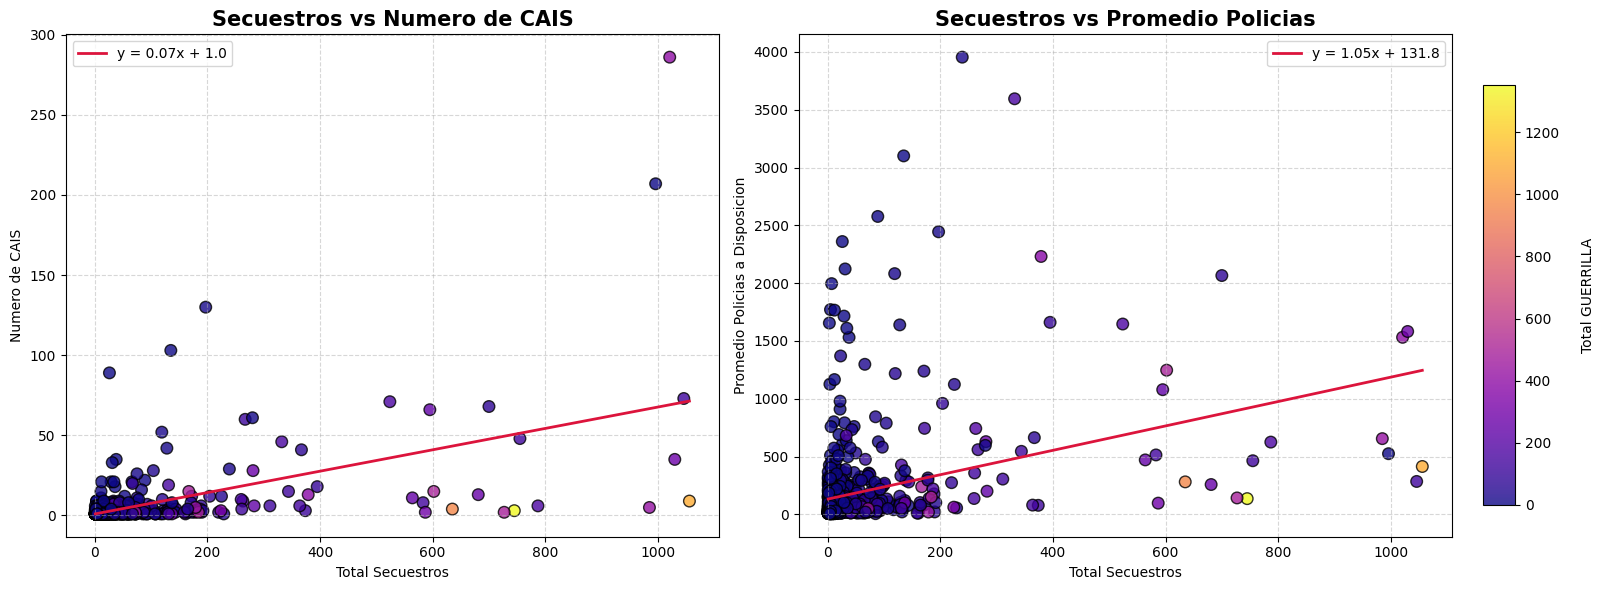

In [143]:

# Agrupar datos
temp = base_sec_violen_seguridad.groupby(['MUNICIPIO']).agg(
    secuestros=('TOTAL', 'sum'),
    cais=('num_cai', 'mean'),
    guerrilla=('GUERRILLA', 'sum'),
    paras =('GRUPO PARAMILITAR', 'sum'),
    n_seguridad=('avg_integrantes', 'mean')
).reset_index()


# Crear varuables temporales para graficar
x1 = temp['secuestros']
y1 = temp['cais']
c1 = temp['guerrilla'] + temp['paras']

mask1 = x1.notna() & y1.notna() & c1.notna() & np.isfinite(x1) & np.isfinite(y1) & np.isfinite(c1)
x1_clean = x1[mask1]
y1_clean = y1[mask1]
c1_clean = c1[mask1]
m1, b1 = np.polyfit(x1_clean, y1_clean, 1)
x2 = temp['secuestros']
y2 = temp['n_seguridad']
c2 = temp['guerrilla'] + temp['paras']


mask = temp[['secuestros', 'cais', 'n_seguridad', 'guerrilla']].notna().all(axis=1)
mask &= np.isfinite(temp[['secuestros', 'cais', 'n_seguridad', 'guerrilla']]).all(axis=1)
data = temp[mask]

x1, y1, c = data['secuestros'], data['cais'], data['guerrilla'] + data['paras']
m1, b1 = np.polyfit(x1, y1, 1)
x2, y2 = data['secuestros'], data['n_seguridad']
m2, b2 = np.polyfit(x2, y2, 1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Primer scatter + regresión

sc1 = ax1.scatter(x1, y1, c=c, cmap='plasma', s=70, alpha=0.8, edgecolor='k')
ax1.plot(np.linspace(x1.min(), x1.max(), 200),m1 * np.linspace(x1.min(), x1.max(), 200) + b1,
         color='crimson', lw=2, label=f'y = {m1:.2f}x + {b1:.1f}')

ax1.set_title('Secuestros vs Numero de CAIS' , fontsize=15, weight='bold')
ax1.set_xlabel('Total Secuestros')
ax1.set_ylabel('Numero de CAIS')
ax1.legend()
ax1.grid(True, ls='--', alpha=0.5)

# Segundo scatter + regresión
sc2 = ax2.scatter(x2, y2, c=c, cmap='plasma', s=70, alpha=0.8, edgecolor='k')
ax2.plot(np.linspace(x2.min(), x2.max(), 200),m2 * np.linspace(x2.min(), x2.max(), 200) + b2,
         color='crimson', lw=2, label=f'y = {m2:.2f}x + {b2:.1f}')

ax2.set_title('Secuestros vs Promedio Policias', fontsize=15 , weight='bold')
ax2.set_xlabel('Total Secuestros')
ax2.set_ylabel('Promedio Policias a Disposicion')
ax2.legend()
ax2.grid(True, ls='--', alpha=0.5)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.set_label('Total GUERRILLA', rotation=90, labelpad=15)

plt.tight_layout(rect=[0, 0, 0.92, 1])  
plt.show()


In both plots, each point represents a municipality and the color gradient indicates the size of the local guerrilla presence.

1. **Kidnappings vs. CAIs**  
   The regression line (y = 0.07x + 1.7) shows a moderate positive relationship: for every 10 additional kidnappings, the number of CAIs increases by approximately 0.07. The reason the estimated beta is positive can be understood mainly as follows: larger cities tend to have both more CAIs and more kidnappings due to their higher population.

   As mentioned earlier, municipalities with greater guerrilla presence (lighter-colored points) tend to fall in the lower part of the plot, confirming that where guerrilla strength was higher, rule of law was weaker and, in many cases, kidnappings were more frequent.

2. **Kidnappings vs. Average Number of Police Officers**  
   Here the slope is even steeper (y = 1.05x + 140.7), indicating that every 10 additional kidnappings are associated with nearly 10 more police officers on average. The point cloud is more dispersed, but again, municipalities with high guerrilla presence (lighter colors) align with high X-axis values (indicating more kidnappings) and fewer police officers.

Together, these plots suggest that the State had several “lost” zones under guerrilla control, where kidnappings were exacerbated. To confirm our hypothesis that the positive regression coefficient is driven by larger cities simply having more people (and thus more kidnappings and greater security), we can recalculate this plot and regression using the kidnapping rate per 100,000 inhabitants. If the coefficient becomes negative, it will mean that in smaller towns—where we’ve already seen higher kidnapping rates and guerrilla presence—there was less law enforcement and more kidnappings.  



### Scattergram with the 100k rate we already created


C:\Users\alejo\AppData\Local\Temp\ipykernel_4176\1133697258.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


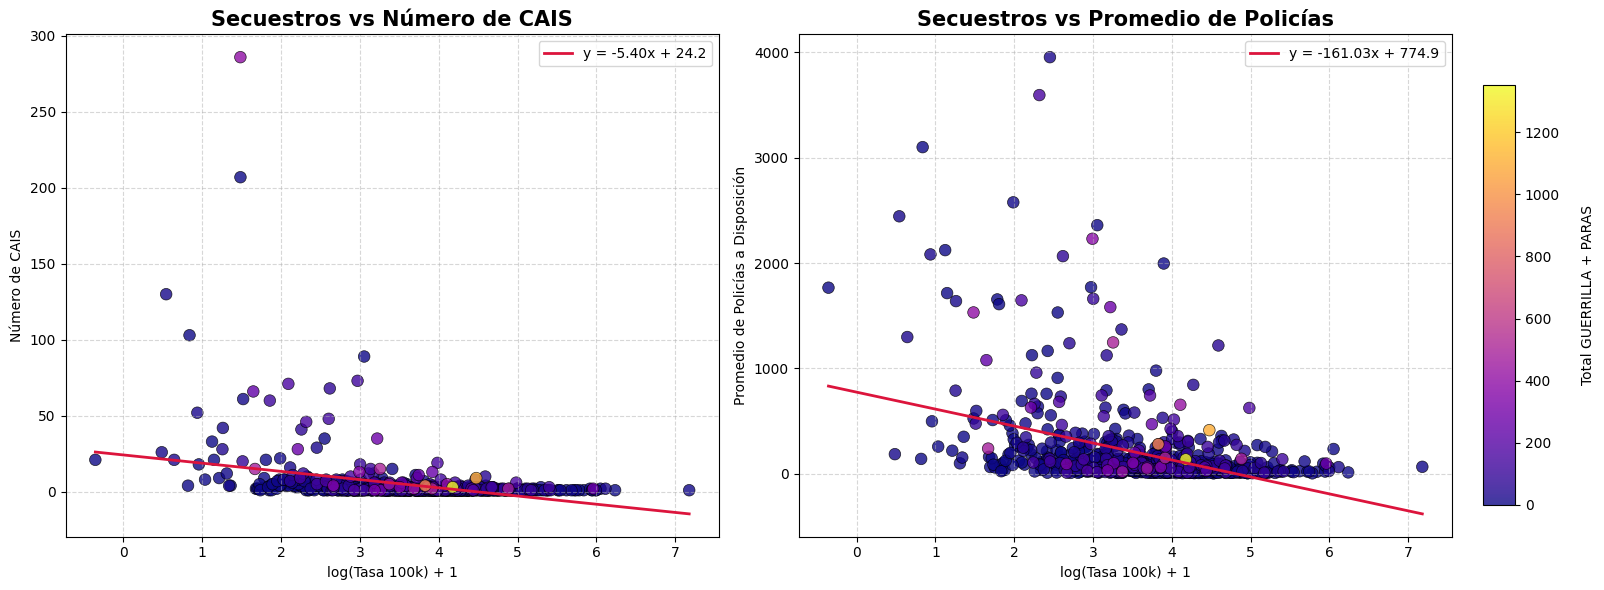

In [139]:
# Agrupar datos
temp = base_sec_violen_seguridad.groupby(['MUNICIPIO']).agg(
    secuestros=('Tasa_100k', 'mean'),
    cais=('num_cai', 'mean'),
    guerrilla=('GUERRILLA', 'sum'),
    paras =('GRUPO PARAMILITAR', 'sum'),
    n_seguridad=('avg_integrantes', 'mean')
).reset_index()

mask = temp[['secuestros','cais','guerrilla','paras','n_seguridad']].notna().all(axis=1)
mask &= np.isfinite(temp[['secuestros','cais','guerrilla','paras','n_seguridad']]).all(axis=1)
data = temp[mask]

x1 = np.log(data['secuestros']) + 1
y1 = data['cais']
c  = data['guerrilla'] + data['paras']

x2 = np.log(data['secuestros']) + 1
y2 = data['n_seguridad']

# Filtrar únicamente valores finitos tras la transformación
mask2 = np.isfinite(x1) & np.isfinite(y1) & np.isfinite(c)
x1_clean = x1[mask2]
y1_clean = y1[mask2]
c_clean = c[mask2]
x2_clean = x2[mask2]
y2_clean = y2[mask2]

# Ordenar de menor a mayor 'c' para que los puntos con más violencia queden encima
order = np.argsort(c_clean)
x1_ord, y1_ord, c_ord = x1_clean.values[order], y1_clean.values[order], c_clean.values[order]
x2_ord, y2_ord        = x2_clean.values[order], y2_clean.values[order]

# Ajuste de la regresión lineal
m1, b1 = np.polyfit(x1_clean, y1_clean, 1)
m2, b2 = np.polyfit(x2_clean, y2_clean, 1)

# Creación de la figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


sc1 = ax1.scatter(x1_ord, y1_ord,c=c_ord, cmap='plasma',s=70, alpha=0.8,edgecolor='k', linewidth=0.5)
x1_line = np.linspace(x1_clean.min(), x1_clean.max(), 200)
ax1.plot(x1_line, m1*x1_line + b1,color='crimson', lw=2,
    label=f'y = {m1:.2f}x + {b1:.1f}')

ax1.set_title('Secuestros vs Número de CAIS', fontsize=15, weight='bold')
ax1.set_xlabel('log(Tasa 100k) + 1')
ax1.set_ylabel('Número de CAIS')
ax1.legend()
ax1.grid(True, ls='--', alpha=0.5)

sc2 = ax2.scatter(x2_ord, y2_ord,
    c=c_ord, cmap='plasma',s=70, alpha=0.8,edgecolor='k', linewidth=0.5)
x2_line = np.linspace(x2_clean.min(), x2_clean.max(), 200)
ax2.plot(x2_line, m2*x2_line + b2,color='crimson', lw=2,
    label=f'y = {m2:.2f}x + {b2:.1f}')

ax2.set_title('Secuestros vs Promedio de Policías', fontsize=15, weight='bold')
ax2.set_xlabel('log(Tasa 100k) + 1')
ax2.set_ylabel('Promedio de Policías a Disposición')
ax2.legend()
ax2.grid(True, ls='--', alpha=0.5)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7]) 
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.set_label('Total GUERRILLA + PARAS', rotation=90, labelpad=15)

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()

When using the logarithm of the kidnapping rate per 100,000 inhabitants on the X-axis (a lin-log model), we observe:

1. **CAIs vs. log-rate**  
   The slope is negative (β≈−5.40), meaning that a percentage increase in the kidnapping rate is associated with **fewer** fixed police posts. The **lighter-colored** points (municipalities with stronger guerrilla presence) appear on the right (high rate) and at the bottom (few CAIs), confirming that the most violent areas had lower institutional coverage.

2. **Police vs. log-rate**  
   Similarly, the negative slope (β≈−161) indicates that a proportional increase in the kidnapping rate is accompanied by a **decrease** in the average number of available officers. Again, the lighter points cluster in the quadrant of high rate and low police presence.

Together, this lin-log model reveals that, once adjusted for population, the municipalities with the strongest guerrilla presence—and therefore the highest rates—were paradoxically the least serviced by security forces.  



### Export base for modeling

In [141]:
base_sec_violen_seguridad.to_csv('Base_Final.csv', index=False, encoding='utf-8')

## Conclusions – Part 2

In this second phase, we combined the **kidnapping rate per 100,000 inhabitants**, proxies of **armed violence** (armed engagements, selective killings, massacres), and **institutional presence** data (CAIs and average number of police officers) to better understand how kidnappings were distributed across the country:

1. **Kidnapping Rate**  
   - The municipalities and departments with the highest rates were not necessarily the most populous, but those with small populations in the Eastern Plains and southern region (Vaupés, Guaviare, Caquetá, Meta). There, even a few kidnappings drive the per-capita rate to extreme levels, reflecting the population impact of the “miracle fishings” during the guerrilla’s heyday.

2. **Violence Proxy**  
   - The massacre bubbles—the most direct signal of guerrilla presence—align almost perfectly with kidnapping hotspots, reinforcing that the epicenters of armed violence were also the most intense kidnapping cores.  
   - Armed engagements and selective killings showed broader dispersion but remained correlated with higher kidnapping counts; this highlights differences among violence modalities and the need to choose the appropriate proxy.

3. **Institutional Presence**  
   - Regression analyses between kidnappings and the number of CAIs or total police officers showed positive relationships: municipalities with more kidnappings and more police received greater infrastructure and personnel deployment, but our hypothesis was that this was driven by large-city bias in the estimated coefficient.  
   - When evaluating the relationship with the **kidnapping rate** (lin-log model), the association reverses sign: municipalities with higher rates—and thus stronger guerrilla presence—have **fewer** CAIs and **fewer** police officers on average, directly indicating that state institutional coverage was minimal in these high-violence, high-rate areas.  
   - This demonstrates that the earlier positive correlation (in absolute terms) was skewed by population size and obscured inadequate coverage in the most affected locations.

Overall, these findings confirm that the **normalized kidnapping rate** reveals territorial vulnerabilities hidden by absolute counts, that **guerrilla violence** (especially massacres) is the best indicator of where kidnappings were concentrated, and that the **institutional response** did not always optimally reach the areas of greatest need. These insights lay the groundwork for modeling socioeconomic determinants and designing targeted interventions in the highest-risk zones.  

 

## **Pablo Reyes** 